In [123]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from pm4py.objects.petri_net.obj import PetriNet, Marking
from pm4py.objects.log.importer.xes import importer as xes_importer
from datetime import date
from pm4py.objects.petri_net.importer import importer as pnml_importer
from pm4py.visualization.petri_net import visualizer as pn_visualizer
import seaborn as sns
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [3]:
log = xes_importer.apply('data/easyroadlog2000.xes')

parsing log, completed traces ::   0%|          | 0/500 [00:00<?, ?it/s]

In [4]:
print(log[0])

{'attributes': {'concept:name': 'A10379'}, 'events': [{'amount': 36.0, 'totalPaymentAmount': 0.0, 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2007, 3, 27, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))), 'dismissal': 'NIL', 'org:resource': '561', 'concept:name': 'Create Fine', 'vehicleClass': 'A', 'points': 0, 'article': 157}, '..', {'lifecycle:transition': 'complete', 'concept:name': 'Send for Credit Collection', 'time:timestamp': datetime.datetime(2009, 3, 30, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200)))}]}


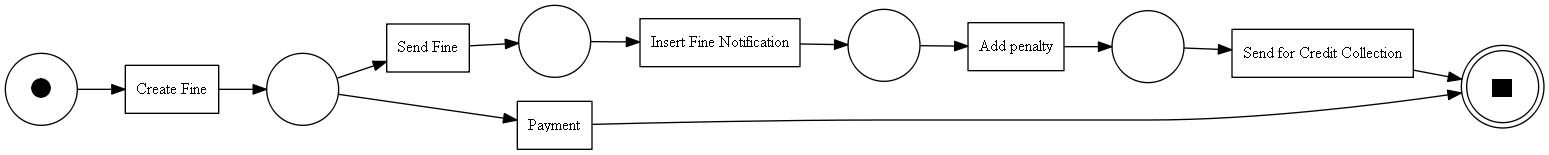

In [5]:
from pm4py.objects.petri_net.importer import importer as pnml_importer
net, initial_marking, final_marking = pnml_importer.apply("data/easyroadpetrinet2000.pnml")    

from pm4py.visualization.petri_net import visualizer as pn_visualizer
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

In [6]:
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
replayed_traces = token_replay.apply(log, net, initial_marking, final_marking)

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
#for trace in replayed_traces:
#    print(trace)

In [8]:
len(replayed_traces)

500

In [9]:
net

places: [ n1, n2, n3, n4, n5, n6 ]
transitions: [ (n10, 'Add penalty'), (n11, 'Send for Credit Collection'), (n12, 'Payment'), (n7, 'Create Fine'), (n8, 'Send Fine'), (n9, 'Insert Fine Notification') ]
arcs: [ (n10, 'Add penalty')->n6, (n11, 'Send for Credit Collection')->n2, (n12, 'Payment')->n2, (n7, 'Create Fine')->n3, (n8, 'Send Fine')->n4, (n9, 'Insert Fine Notification')->n5, n1->(n7, 'Create Fine'), n3->(n12, 'Payment'), n3->(n8, 'Send Fine'), n4->(n9, 'Insert Fine Notification'), n5->(n10, 'Add penalty'), n6->(n11, 'Send for Credit Collection') ]

In [10]:
##usage= get_labels_set(input_transition_set)
def get_labels_set(input_transition_set):
    label_set=set()
    for transition in input_transition_set:
        label_set.add(transition._Transition__get_label())
    return label_set

In [11]:
##usage= get_input_transitions('n4')
def get_initial_start(intial_place):
    for place in net.places:
        if place._Place__get_name()==intial_place:
            initial_start=place
    return initial_start

In [12]:
##usage= get_input_transitions(net,initial_start)
def get_input_transitions(net,place):
    transition=list()
    if place in net.places:
        for arc in net.arcs:
            if arc._Arc__get_target()==place:
                if arc._Arc__get_source()._Transition__get_label() is None:
                    for new_place in arc._Arc__get_source()._Transition__get_in_arcs():
                        transition.extend(get_input_transitions(net,new_place._Arc__get_source()))
                else:
                    transition.append(arc._Arc__get_source())
        return transition
    else:
        return None

In [13]:
##usage= get_output_transitions(net,initial_start)
def get_output_transitions(net,place):
    transition=list()
    if place in net.places:
        for arc in net.arcs:
            if arc._Arc__get_source()==place:
                if arc._Arc__get_target()._Transition__get_label() is None:
                    for new_place in arc._Arc__get_target()._Transition__get_out_arcs():
                        transition.extend(get_output_transitions(net,new_place._Arc__get_target()))
                else:
                    transition.append(arc._Arc__get_target())
        return transition
    else:
        return None

### place n3 for batching test
Inputs:  
    (n15, 'Create Fine')->n3
    
Outputs: 
    n3->(n17, 'Send Fine')

In [15]:
input_transition_set=set()
input_transition_label_set=set()
output_transition_set=set()
output_transition_label_set=set()
for start in ['n3','n4']:
    initial_start=get_initial_start(start)
    input_transition_set|=set(get_input_transitions(net,initial_start))
    output_transition_set|=set(get_output_transitions(net,initial_start))
    temp=input_transition_set.difference(output_transition_set)
    output_transition_set.difference_update(input_transition_set)
    input_transition_set=temp

input_transition_label_set|=get_labels_set(input_transition_set)
output_transition_label_set|=get_labels_set(output_transition_set)

    
print(input_transition_set)
print(input_transition_label_set)
print(output_transition_set)
print(output_transition_label_set)

token_produced=0
token_consumed=0
token_left=0
predictordf=pd.DataFrame(columns= ['StartEvent','StartTime','EndEvent','EndTime','User'])
for trace,case in zip(replayed_traces, log):
    last_event=None
    first_event=None
    if trace['trace_is_fit']==True:
        for active_trace in trace['activated_transitions']:
            if active_trace in input_transition_set :
                for events in case:
                    if events['concept:name'] in input_transition_label_set:
                        last_event=events
            if active_trace in output_transition_set:
                for events in case:
                    if events['concept:name'] in output_transition_label_set and first_event is None:
                        first_event=events
    if last_event is not None and first_event is not None:
        token_produced=token_produced+1
        token_consumed=token_consumed+1
        row_df = pd.DataFrame([[last_event['concept:name'], last_event['time:timestamp'],first_event['concept:name'], first_event['time:timestamp'], case.attributes['concept:name']]],columns= ['StartEvent','StartTime','EndEvent','EndTime','User'])
        predictordf = pd.concat([row_df, predictordf], ignore_index=True)
    
print(token_produced)
print(token_consumed)

predictordf

{(n7, 'Create Fine')}
{'Create Fine'}
{(n12, 'Payment'), (n9, 'Insert Fine Notification')}
{'Insert Fine Notification', 'Payment'}
500
500


,StartEvent,StartTime,EndEvent,EndTime,User
0,Create Fine,2002-07-31 00:00:00+02:00,Insert Fine Notification,2002-11-02 00:00:00+01:00,V9578
1,Create Fine,2001-06-26 00:00:00+02:00,Insert Fine Notification,2001-07-26 00:00:00+02:00,V7381
2,Create Fine,2000-10-26 00:00:00+02:00,Insert Fine Notification,2001-01-12 00:00:00+01:00,V6976
3,Create Fine,2000-08-12 00:00:00+02:00,Insert Fine Notification,2000-12-14 00:00:00+01:00,V6468
4,Create Fine,2000-07-19 00:00:00+02:00,Insert Fine Notification,2000-11-19 00:00:00+01:00,V6016
...,...,...,...,...,...
495,Create Fine,2007-04-11 00:00:00+02:00,Insert Fine Notification,2007-08-20 00:00:00+02:00,A11198
496,Create Fine,2007-04-16 00:00:00+02:00,Payment,2007-04-17 00:00:00+02:00,A11072
497,Create Fine,2007-03-21 00:00:00+01:00,Insert Fine Notification,2007-07-25 00:00:00+02:00,A10751
498,Create Fine,2007-09-13 00:00:00+02:00,Payment,2007-11-10 00:00:00+01:00,A10685


{(n15, 'Create Fine')}


{(n15, 'Create Fine'), (n17, 'Send Fine')}

In [17]:
print(len(replayed_traces))

2000


In [16]:
predictordf['StartDateTime'] = pd.to_datetime(predictordf['StartTime'], utc=True)
predictordf['StartDate'] = pd.to_datetime(predictordf['StartDateTime']).dt.date
predictordf['EndDateTime'] = pd.to_datetime(predictordf['EndTime'], utc=True)
predictordf['EndDate'] = pd.to_datetime(predictordf['EndDateTime']).dt.date
predictordf['TotalWaitingTime']=  (pd.to_datetime(predictordf['EndTime'], utc=True)-pd.to_datetime(predictordf['StartTime'], utc=True))
minstartdate=min(predictordf['StartDate'])
maxenddate=max(predictordf['EndDate'])

In [17]:
predictordatedataframe = pd.DataFrame({'date':pd.date_range(start=minstartdate, end=maxenddate),'tokenproduced':0,'tokenconsumed':0,'tokenleft':0,'WaitingTime':0,'Count':0})
predictordatedataframe 

,date,tokenproduced,tokenconsumed,tokenleft,WaitingTime,Count
0,2000-01-04,0,0,0,0,0
1,2000-01-05,0,0,0,0,0
2,2000-01-06,0,0,0,0,0
3,2000-01-07,0,0,0,0,0
4,2000-01-08,0,0,0,0,0
...,...,...,...,...,...,...
4829,2013-03-25,0,0,0,0,0
4830,2013-03-26,0,0,0,0,0
4831,2013-03-27,0,0,0,0,0
4832,2013-03-28,0,0,0,0,0


In [18]:
from datetime import timedelta as td
for index, row in predictordatedataframe.iterrows():
    currentdate=row['date']
    produced=0
    left=0
    consumed=0
    waiting=td(days=0)
    waitingdays=0
    #print(type(waiting))
    count=0
    if currentdate.strftime('%Y-%m-%d')<='1999-10-13':
        continue
    print(currentdate.strftime('%Y-%m-%d'))
    for indexdata, rowdata in predictordf.iterrows():
        StartDate=rowdata['StartDate']
        EndDate=rowdata['EndDate']
        #TotalWaitingTime=rowdata['TotalWaitingTime']
        TotalWaitingTime=rowdata['TotalWaitingTime']
        #print(type(waiting)," ",type(TotalWaitingTime))
        WaitingTimeTillDate=currentdate+td(hours=24)
        if currentdate.date()==StartDate:
            produced=produced+1
        if currentdate.date()==EndDate:
            consumed=consumed+1
            WaitingTimeTillDate=rowdata['EndDateTime']
        if currentdate.date()<EndDate and currentdate.date()>=StartDate:
            left=left+1
        if currentdate.date()<=EndDate and currentdate.date()>=StartDate:
            TotalWaitingTime=WaitingTimeTillDate.replace(tzinfo=None)-rowdata['StartDateTime'].replace(tzinfo=None)
            if waiting is None:
                waiting=TotalWaitingTime
            else:
                if waiting.days<100000:
                    waiting=waiting+TotalWaitingTime
                    waitingdays=waiting.days
                else :
                    waitingdays=TotalWaitingTime.days+waitingdays
            count=count+1
    predictordatedataframe.at[index, 'tokenproduced']=produced
    predictordatedataframe.at[index, 'tokenconsumed']=consumed
    predictordatedataframe.at[index, 'tokenleft']=left
    if waiting.days<100000:
        predictordatedataframe.at[index, 'WaitingTime']=waiting
    else:
        predictordatedataframe.at[index, 'WaitingTime']=waitingdays
    predictordatedataframe.at[index, 'Count']=count

2000-01-04
2000-01-05
2000-01-06
2000-01-07
2000-01-08
2000-01-09
2000-01-10
2000-01-11
2000-01-12
2000-01-13
2000-01-14
2000-01-15
2000-01-16
2000-01-17
2000-01-18
2000-01-19
2000-01-20
2000-01-21
2000-01-22
2000-01-23
2000-01-24
2000-01-25
2000-01-26
2000-01-27
2000-01-28
2000-01-29
2000-01-30
2000-01-31
2000-02-01
2000-02-02
2000-02-03
2000-02-04
2000-02-05
2000-02-06
2000-02-07
2000-02-08
2000-02-09
2000-02-10
2000-02-11
2000-02-12
2000-02-13
2000-02-14
2000-02-15
2000-02-16
2000-02-17
2000-02-18
2000-02-19
2000-02-20
2000-02-21
2000-02-22
2000-02-23
2000-02-24
2000-02-25
2000-02-26
2000-02-27
2000-02-28
2000-02-29
2000-03-01
2000-03-02
2000-03-03
2000-03-04
2000-03-05
2000-03-06
2000-03-07
2000-03-08
2000-03-09
2000-03-10
2000-03-11
2000-03-12
2000-03-13
2000-03-14
2000-03-15
2000-03-16
2000-03-17
2000-03-18
2000-03-19
2000-03-20
2000-03-21
2000-03-22
2000-03-23
2000-03-24
2000-03-25
2000-03-26
2000-03-27
2000-03-28
2000-03-29
2000-03-30
2000-03-31
2000-04-01
2000-04-02
2000-04-03

2002-01-19
2002-01-20
2002-01-21
2002-01-22
2002-01-23
2002-01-24
2002-01-25
2002-01-26
2002-01-27
2002-01-28
2002-01-29
2002-01-30
2002-01-31
2002-02-01
2002-02-02
2002-02-03
2002-02-04
2002-02-05
2002-02-06
2002-02-07
2002-02-08
2002-02-09
2002-02-10
2002-02-11
2002-02-12
2002-02-13
2002-02-14
2002-02-15
2002-02-16
2002-02-17
2002-02-18
2002-02-19
2002-02-20
2002-02-21
2002-02-22
2002-02-23
2002-02-24
2002-02-25
2002-02-26
2002-02-27
2002-02-28
2002-03-01
2002-03-02
2002-03-03
2002-03-04
2002-03-05
2002-03-06
2002-03-07
2002-03-08
2002-03-09
2002-03-10
2002-03-11
2002-03-12
2002-03-13
2002-03-14
2002-03-15
2002-03-16
2002-03-17
2002-03-18
2002-03-19
2002-03-20
2002-03-21
2002-03-22
2002-03-23
2002-03-24
2002-03-25
2002-03-26
2002-03-27
2002-03-28
2002-03-29
2002-03-30
2002-03-31
2002-04-01
2002-04-02
2002-04-03
2002-04-04
2002-04-05
2002-04-06
2002-04-07
2002-04-08
2002-04-09
2002-04-10
2002-04-11
2002-04-12
2002-04-13
2002-04-14
2002-04-15
2002-04-16
2002-04-17
2002-04-18
2002-04-19

2004-02-03
2004-02-04
2004-02-05
2004-02-06
2004-02-07
2004-02-08
2004-02-09
2004-02-10
2004-02-11
2004-02-12
2004-02-13
2004-02-14
2004-02-15
2004-02-16
2004-02-17
2004-02-18
2004-02-19
2004-02-20
2004-02-21
2004-02-22
2004-02-23
2004-02-24
2004-02-25
2004-02-26
2004-02-27
2004-02-28
2004-02-29
2004-03-01
2004-03-02
2004-03-03
2004-03-04
2004-03-05
2004-03-06
2004-03-07
2004-03-08
2004-03-09
2004-03-10
2004-03-11
2004-03-12
2004-03-13
2004-03-14
2004-03-15
2004-03-16
2004-03-17
2004-03-18
2004-03-19
2004-03-20
2004-03-21
2004-03-22
2004-03-23
2004-03-24
2004-03-25
2004-03-26
2004-03-27
2004-03-28
2004-03-29
2004-03-30
2004-03-31
2004-04-01
2004-04-02
2004-04-03
2004-04-04
2004-04-05
2004-04-06
2004-04-07
2004-04-08
2004-04-09
2004-04-10
2004-04-11
2004-04-12
2004-04-13
2004-04-14
2004-04-15
2004-04-16
2004-04-17
2004-04-18
2004-04-19
2004-04-20
2004-04-21
2004-04-22
2004-04-23
2004-04-24
2004-04-25
2004-04-26
2004-04-27
2004-04-28
2004-04-29
2004-04-30
2004-05-01
2004-05-02
2004-05-03

2006-02-19
2006-02-20
2006-02-21
2006-02-22
2006-02-23
2006-02-24
2006-02-25
2006-02-26
2006-02-27
2006-02-28
2006-03-01
2006-03-02
2006-03-03
2006-03-04
2006-03-05
2006-03-06
2006-03-07
2006-03-08
2006-03-09
2006-03-10
2006-03-11
2006-03-12
2006-03-13
2006-03-14
2006-03-15
2006-03-16
2006-03-17
2006-03-18
2006-03-19
2006-03-20
2006-03-21
2006-03-22
2006-03-23
2006-03-24
2006-03-25
2006-03-26
2006-03-27
2006-03-28
2006-03-29
2006-03-30
2006-03-31
2006-04-01
2006-04-02
2006-04-03
2006-04-04
2006-04-05
2006-04-06
2006-04-07
2006-04-08
2006-04-09
2006-04-10
2006-04-11
2006-04-12
2006-04-13
2006-04-14
2006-04-15
2006-04-16
2006-04-17
2006-04-18
2006-04-19
2006-04-20
2006-04-21
2006-04-22
2006-04-23
2006-04-24
2006-04-25
2006-04-26
2006-04-27
2006-04-28
2006-04-29
2006-04-30
2006-05-01
2006-05-02
2006-05-03
2006-05-04
2006-05-05
2006-05-06
2006-05-07
2006-05-08
2006-05-09
2006-05-10
2006-05-11
2006-05-12
2006-05-13
2006-05-14
2006-05-15
2006-05-16
2006-05-17
2006-05-18
2006-05-19
2006-05-20

2008-03-07
2008-03-08
2008-03-09
2008-03-10
2008-03-11
2008-03-12
2008-03-13
2008-03-14
2008-03-15
2008-03-16
2008-03-17
2008-03-18
2008-03-19
2008-03-20
2008-03-21
2008-03-22
2008-03-23
2008-03-24
2008-03-25
2008-03-26
2008-03-27
2008-03-28
2008-03-29
2008-03-30
2008-03-31
2008-04-01
2008-04-02
2008-04-03
2008-04-04
2008-04-05
2008-04-06
2008-04-07
2008-04-08
2008-04-09
2008-04-10
2008-04-11
2008-04-12
2008-04-13
2008-04-14
2008-04-15
2008-04-16
2008-04-17
2008-04-18
2008-04-19
2008-04-20
2008-04-21
2008-04-22
2008-04-23
2008-04-24
2008-04-25
2008-04-26
2008-04-27
2008-04-28
2008-04-29
2008-04-30
2008-05-01
2008-05-02
2008-05-03
2008-05-04
2008-05-05
2008-05-06
2008-05-07
2008-05-08
2008-05-09
2008-05-10
2008-05-11
2008-05-12
2008-05-13
2008-05-14
2008-05-15
2008-05-16
2008-05-17
2008-05-18
2008-05-19
2008-05-20
2008-05-21
2008-05-22
2008-05-23
2008-05-24
2008-05-25
2008-05-26
2008-05-27
2008-05-28
2008-05-29
2008-05-30
2008-05-31
2008-06-01
2008-06-02
2008-06-03
2008-06-04
2008-06-05

2010-03-23
2010-03-24
2010-03-25
2010-03-26
2010-03-27
2010-03-28
2010-03-29
2010-03-30
2010-03-31
2010-04-01
2010-04-02
2010-04-03
2010-04-04
2010-04-05
2010-04-06
2010-04-07
2010-04-08
2010-04-09
2010-04-10
2010-04-11
2010-04-12
2010-04-13
2010-04-14
2010-04-15
2010-04-16
2010-04-17
2010-04-18
2010-04-19
2010-04-20
2010-04-21
2010-04-22
2010-04-23
2010-04-24
2010-04-25
2010-04-26
2010-04-27
2010-04-28
2010-04-29
2010-04-30
2010-05-01
2010-05-02
2010-05-03
2010-05-04
2010-05-05
2010-05-06
2010-05-07
2010-05-08
2010-05-09
2010-05-10
2010-05-11
2010-05-12
2010-05-13
2010-05-14
2010-05-15
2010-05-16
2010-05-17
2010-05-18
2010-05-19
2010-05-20
2010-05-21
2010-05-22
2010-05-23
2010-05-24
2010-05-25
2010-05-26
2010-05-27
2010-05-28
2010-05-29
2010-05-30
2010-05-31
2010-06-01
2010-06-02
2010-06-03
2010-06-04
2010-06-05
2010-06-06
2010-06-07
2010-06-08
2010-06-09
2010-06-10
2010-06-11
2010-06-12
2010-06-13
2010-06-14
2010-06-15
2010-06-16
2010-06-17
2010-06-18
2010-06-19
2010-06-20
2010-06-21

2012-04-07
2012-04-08
2012-04-09
2012-04-10
2012-04-11
2012-04-12
2012-04-13
2012-04-14
2012-04-15
2012-04-16
2012-04-17
2012-04-18
2012-04-19
2012-04-20
2012-04-21
2012-04-22
2012-04-23
2012-04-24
2012-04-25
2012-04-26
2012-04-27
2012-04-28
2012-04-29
2012-04-30
2012-05-01
2012-05-02
2012-05-03
2012-05-04
2012-05-05
2012-05-06
2012-05-07
2012-05-08
2012-05-09
2012-05-10
2012-05-11
2012-05-12
2012-05-13
2012-05-14
2012-05-15
2012-05-16
2012-05-17
2012-05-18
2012-05-19
2012-05-20
2012-05-21
2012-05-22
2012-05-23
2012-05-24
2012-05-25
2012-05-26
2012-05-27
2012-05-28
2012-05-29
2012-05-30
2012-05-31
2012-06-01
2012-06-02
2012-06-03
2012-06-04
2012-06-05
2012-06-06
2012-06-07
2012-06-08
2012-06-09
2012-06-10
2012-06-11
2012-06-12
2012-06-13
2012-06-14
2012-06-15
2012-06-16
2012-06-17
2012-06-18
2012-06-19
2012-06-20
2012-06-21
2012-06-22
2012-06-23
2012-06-24
2012-06-25
2012-06-26
2012-06-27
2012-06-28
2012-06-29
2012-06-30
2012-07-01
2012-07-02
2012-07-03
2012-07-04
2012-07-05
2012-07-06

In [25]:
predictordatedataframe.sort_values(by='tokenconsumed')

,date,tokenproduced,tokenconsumed,tokenleft,WaitingTime,Count
0,2000-01-04,1,0,1,0 days 01:00:00,1
2930,2008-01-12,0,0,4,232 days 05:00:00,4
2932,2008-01-14,0,0,4,98 days 04:00:00,4
2933,2008-01-15,0,0,4,102 days 04:00:00,4
2934,2008-01-16,0,0,4,106 days 04:00:00,4
...,...,...,...,...,...,...
980,2002-09-10,0,3,9,583 days 18:00:00,12
3845,2010-07-15,0,3,7,524 days 12:00:00,10
943,2002-08-04,0,3,10,333 days 20:00:00,13
2905,2007-12-18,0,4,8,1172 days 17:00:00,12


In [20]:
predictordatedataframe.to_csv (r'C:\Users\bittu\RWTH\Thesis\easyroadfine2000samplepredictordatedataframe.csv', index= False, header=True)


<AxesSubplot:xlabel='tokenconsumed', ylabel='Count'>

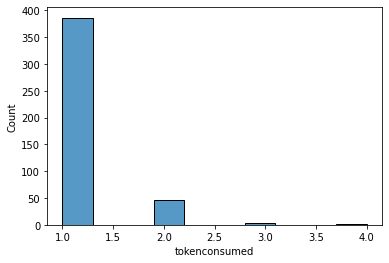

In [22]:
sns.histplot(data=predictordatedataframe[predictordatedataframe['tokenconsumed']>0], x="tokenconsumed")

In [107]:
def categorise(row):  
    if type( row['WaitingTime']) is int :
        return row['WaitingTime']
    return row['WaitingTime'].days
predictordatedataframe['WaitingDays'] = predictordatedataframe.apply(lambda row: categorise(row), axis=1)

def categorise(row):   
    if row['Count']==0:
        return 0
    return row['WaitingDays']/row['Count']

predictordatedataframe['AverageWaitingTime'] = predictordatedataframe.apply(lambda row: categorise(row), axis=1)


In [23]:
tokenconsumedmean=predictordatedataframe[predictordatedataframe['tokenconsumed']!=0][["tokenconsumed"]].mean()
print(tokenconsumedmean)

tokenconsumed    1.138952
dtype: float64


In [44]:
def categorise(row):   
    if row['tokenconsumed'] > 5 :
        return 1
    return 0

predictordatedataframe['batched'] = predictordatedataframe.apply(lambda row: categorise(row), axis=1)

In [177]:
for trace,case in zip(replayed_traces, log):
    print(trace)
    print("")
    print(case)
    for events in case:
        print(events)
        
        
    break

{'trace_is_fit': True, 'trace_fitness': 1.0, 'activated_transitions': [(n15, 'Create Fine'), (n17, 'Send Fine'), (n19, None), (n21, 'Insert Fine Notification'), (n22, None), (n20, None), (n24, None), (n29, 'Add penalty'), (n30, None), (n32, None), (n35, 'Send for Credit Collection')], 'reached_marking': ['n2:1'], 'enabled_transitions_in_marking': set(), 'transitions_with_problems': [], 'missing_tokens': 0, 'consumed_tokens': 13, 'remaining_tokens': 0, 'produced_tokens': 13}

{'attributes': {'concept:name': 'A10025'}, 'events': [{'amount': 36.0, 'totalPaymentAmount': 0.0, 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2007, 3, 22, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'dismissal': 'NIL', 'org:resource': '537', 'concept:name': 'Create Fine', 'vehicleClass': 'A', 'points': 0, 'article': 157}, '..', {'lifecycle:transition': 'complete', 'concept:name': 'Send for Credit Collection', 'time:timestamp': datetime.datetime(2009, 3, 30, 0, 0, t

### place n3 for batching test
Inputs:  
    (n15, 'Create Fine')->n3
    
Outputs: 
    n3->(n17, 'Send Fine')

In [26]:
input_transition_set=set()
input_transition_label_set=set()
output_transition_set=set()
output_transition_label_set=set()
for start in ['n6']:
    initial_start=get_initial_start(start)
    input_transition_set|=set(get_input_transitions(net,initial_start))
    output_transition_set|=set(get_output_transitions(net,initial_start))
    temp=input_transition_set.difference(output_transition_set)
    output_transition_set.difference_update(input_transition_set)
    input_transition_set=temp

input_transition_label_set|=get_labels_set(input_transition_set)
output_transition_label_set|=get_labels_set(output_transition_set)

    
print(input_transition_set)
print(input_transition_label_set)
print(output_transition_set)
print(output_transition_label_set)

token_produced=0
token_consumed=0
token_left=0
predictordf=pd.DataFrame(columns= ['StartEvent','StartTime','EndEvent','EndTime','User'])
for trace,case in zip(replayed_traces, log):
    last_event=None
    first_event=None
    if trace['trace_is_fit']==True:
        for active_trace in trace['activated_transitions']:
            if active_trace in input_transition_set :
                for events in case:
                    if events['concept:name'] in input_transition_label_set:
                        last_event=events
            if active_trace in output_transition_set:
                for events in case:
                    if events['concept:name'] in output_transition_label_set and first_event is None:
                        first_event=events
    if last_event is not None and first_event is not None:
        token_produced=token_produced+1
        token_consumed=token_consumed+1
        row_df = pd.DataFrame([[last_event['concept:name'], last_event['time:timestamp'],first_event['concept:name'], first_event['time:timestamp'], case.attributes['concept:name']]],columns= ['StartEvent','StartTime','EndEvent','EndTime','User'])
        predictordf = pd.concat([row_df, predictordf], ignore_index=True)
    
print(token_produced)
print(token_consumed)

predictordf

{(n10, 'Add penalty')}
{'Add penalty'}
{(n11, 'Send for Credit Collection')}
{'Send for Credit Collection'}
289
289


,StartEvent,StartTime,EndEvent,EndTime,User
0,Add penalty,2003-01-01 00:00:00+01:00,Send for Credit Collection,2004-01-10 00:00:00+01:00,V9578
1,Add penalty,2001-09-24 00:00:00+02:00,Send for Credit Collection,2003-01-10 00:00:00+01:00,V7381
2,Add penalty,2001-03-13 00:00:00+01:00,Send for Credit Collection,2002-04-10 00:00:00+02:00,V6976
3,Add penalty,2001-02-12 00:00:00+01:00,Send for Credit Collection,2002-04-10 00:00:00+02:00,V6468
4,Add penalty,2001-01-18 00:00:00+01:00,Send for Credit Collection,2002-04-10 00:00:00+02:00,V6016
...,...,...,...,...,...
284,Add penalty,2007-10-09 00:00:00+02:00,Send for Credit Collection,2009-03-30 00:00:00+02:00,A11755
285,Add penalty,2007-06-15 00:00:00+02:00,Send for Credit Collection,2009-03-30 00:00:00+02:00,A1158
286,Add penalty,2007-10-19 00:00:00+02:00,Send for Credit Collection,2009-03-30 00:00:00+02:00,A11198
287,Add penalty,2007-09-23 00:00:00+02:00,Send for Credit Collection,2009-03-30 00:00:00+02:00,A10751


In [27]:
print(len(replayed_traces))

500


In [28]:
predictordf['StartDateTime'] = pd.to_datetime(predictordf['StartTime'], utc=True)
predictordf['StartDate'] = pd.to_datetime(predictordf['StartDateTime']).dt.date
predictordf['EndDateTime'] = pd.to_datetime(predictordf['EndTime'], utc=True)
predictordf['EndDate'] = pd.to_datetime(predictordf['EndDateTime']).dt.date
predictordf['TotalWaitingTime']=  (pd.to_datetime(predictordf['EndTime'], utc=True)-pd.to_datetime(predictordf['StartTime'], utc=True))
minstartdate=min(predictordf['StartDate'])
maxenddate=max(predictordf['EndDate'])

In [29]:
targetdatedataframe = pd.DataFrame({'date':pd.date_range(start=minstartdate, end=maxenddate),'tokenproduced':0,'tokenconsumed':0,'tokenleft':0,'WaitingTime':0,'Count':0})
targetdatedataframe 

,date,tokenproduced,tokenconsumed,tokenleft,WaitingTime,Count
0,2000-03-17,0,0,0,0,0
1,2000-03-18,0,0,0,0,0
2,2000-03-19,0,0,0,0,0
3,2000-03-20,0,0,0,0,0
4,2000-03-21,0,0,0,0,0
...,...,...,...,...,...,...
4781,2013-04-19,0,0,0,0,0
4782,2013-04-20,0,0,0,0,0
4783,2013-04-21,0,0,0,0,0
4784,2013-04-22,0,0,0,0,0


In [30]:
from datetime import timedelta as td
for index, row in targetdatedataframe.iterrows():
    currentdate=row['date']
    produced=0
    left=0
    consumed=0
    waiting=td(days=0)
    waitingdays=0
    #print(type(waiting))
    count=0
    if currentdate.strftime('%Y-%m-%d')<='1999-10-13':
        continue
    print(currentdate.strftime('%Y-%m-%d'))
    for indexdata, rowdata in predictordf.iterrows():
        StartDate=rowdata['StartDate']
        EndDate=rowdata['EndDate']
        #TotalWaitingTime=rowdata['TotalWaitingTime']
        TotalWaitingTime=rowdata['TotalWaitingTime']
        #print(type(waiting)," ",type(TotalWaitingTime))
        WaitingTimeTillDate=currentdate+td(hours=24)
        if currentdate.date()==StartDate:
            produced=produced+1
        if currentdate.date()==EndDate:
            consumed=consumed+1
            WaitingTimeTillDate=rowdata['EndDateTime']
        if currentdate.date()<EndDate and currentdate.date()>=StartDate:
            left=left+1
        if currentdate.date()<=EndDate and currentdate.date()>=StartDate:
            TotalWaitingTime=WaitingTimeTillDate.replace(tzinfo=None)-rowdata['StartDateTime'].replace(tzinfo=None)
            if waiting is None:
                waiting=TotalWaitingTime
            else:
                if waiting.days<100000:
                    waiting=waiting+TotalWaitingTime
                    waitingdays=waiting.days
                else :
                    waitingdays=TotalWaitingTime.days+waitingdays
            count=count+1
    targetdatedataframe.at[index, 'tokenproduced']=produced
    targetdatedataframe.at[index, 'tokenconsumed']=consumed
    targetdatedataframe.at[index, 'tokenleft']=left
    if waiting.days<100000:
        targetdatedataframe.at[index, 'WaitingTime']=waiting
    else:
        targetdatedataframe.at[index, 'WaitingTime']=waitingdays
    targetdatedataframe.at[index, 'Count']=count

2000-03-17
2000-03-18
2000-03-19
2000-03-20
2000-03-21
2000-03-22
2000-03-23
2000-03-24
2000-03-25
2000-03-26
2000-03-27
2000-03-28
2000-03-29
2000-03-30
2000-03-31
2000-04-01
2000-04-02
2000-04-03
2000-04-04
2000-04-05
2000-04-06
2000-04-07
2000-04-08
2000-04-09
2000-04-10
2000-04-11
2000-04-12
2000-04-13
2000-04-14
2000-04-15
2000-04-16
2000-04-17
2000-04-18
2000-04-19
2000-04-20
2000-04-21
2000-04-22
2000-04-23
2000-04-24
2000-04-25
2000-04-26
2000-04-27
2000-04-28
2000-04-29
2000-04-30
2000-05-01
2000-05-02
2000-05-03
2000-05-04
2000-05-05
2000-05-06
2000-05-07
2000-05-08
2000-05-09
2000-05-10
2000-05-11
2000-05-12
2000-05-13
2000-05-14
2000-05-15
2000-05-16
2000-05-17
2000-05-18
2000-05-19
2000-05-20
2000-05-21
2000-05-22
2000-05-23
2000-05-24
2000-05-25
2000-05-26
2000-05-27
2000-05-28
2000-05-29
2000-05-30
2000-05-31
2000-06-01
2000-06-02
2000-06-03
2000-06-04
2000-06-05
2000-06-06
2000-06-07
2000-06-08
2000-06-09
2000-06-10
2000-06-11
2000-06-12
2000-06-13
2000-06-14
2000-06-15

2002-04-05
2002-04-06
2002-04-07
2002-04-08
2002-04-09
2002-04-10
2002-04-11
2002-04-12
2002-04-13
2002-04-14
2002-04-15
2002-04-16
2002-04-17
2002-04-18
2002-04-19
2002-04-20
2002-04-21
2002-04-22
2002-04-23
2002-04-24
2002-04-25
2002-04-26
2002-04-27
2002-04-28
2002-04-29
2002-04-30
2002-05-01
2002-05-02
2002-05-03
2002-05-04
2002-05-05
2002-05-06
2002-05-07
2002-05-08
2002-05-09
2002-05-10
2002-05-11
2002-05-12
2002-05-13
2002-05-14
2002-05-15
2002-05-16
2002-05-17
2002-05-18
2002-05-19
2002-05-20
2002-05-21
2002-05-22
2002-05-23
2002-05-24
2002-05-25
2002-05-26
2002-05-27
2002-05-28
2002-05-29
2002-05-30
2002-05-31
2002-06-01
2002-06-02
2002-06-03
2002-06-04
2002-06-05
2002-06-06
2002-06-07
2002-06-08
2002-06-09
2002-06-10
2002-06-11
2002-06-12
2002-06-13
2002-06-14
2002-06-15
2002-06-16
2002-06-17
2002-06-18
2002-06-19
2002-06-20
2002-06-21
2002-06-22
2002-06-23
2002-06-24
2002-06-25
2002-06-26
2002-06-27
2002-06-28
2002-06-29
2002-06-30
2002-07-01
2002-07-02
2002-07-03
2002-07-04

2004-04-23
2004-04-24
2004-04-25
2004-04-26
2004-04-27
2004-04-28
2004-04-29
2004-04-30
2004-05-01
2004-05-02
2004-05-03
2004-05-04
2004-05-05
2004-05-06
2004-05-07
2004-05-08
2004-05-09
2004-05-10
2004-05-11
2004-05-12
2004-05-13
2004-05-14
2004-05-15
2004-05-16
2004-05-17
2004-05-18
2004-05-19
2004-05-20
2004-05-21
2004-05-22
2004-05-23
2004-05-24
2004-05-25
2004-05-26
2004-05-27
2004-05-28
2004-05-29
2004-05-30
2004-05-31
2004-06-01
2004-06-02
2004-06-03
2004-06-04
2004-06-05
2004-06-06
2004-06-07
2004-06-08
2004-06-09
2004-06-10
2004-06-11
2004-06-12
2004-06-13
2004-06-14
2004-06-15
2004-06-16
2004-06-17
2004-06-18
2004-06-19
2004-06-20
2004-06-21
2004-06-22
2004-06-23
2004-06-24
2004-06-25
2004-06-26
2004-06-27
2004-06-28
2004-06-29
2004-06-30
2004-07-01
2004-07-02
2004-07-03
2004-07-04
2004-07-05
2004-07-06
2004-07-07
2004-07-08
2004-07-09
2004-07-10
2004-07-11
2004-07-12
2004-07-13
2004-07-14
2004-07-15
2004-07-16
2004-07-17
2004-07-18
2004-07-19
2004-07-20
2004-07-21
2004-07-22

2006-05-13
2006-05-14
2006-05-15
2006-05-16
2006-05-17
2006-05-18
2006-05-19
2006-05-20
2006-05-21
2006-05-22
2006-05-23
2006-05-24
2006-05-25
2006-05-26
2006-05-27
2006-05-28
2006-05-29
2006-05-30
2006-05-31
2006-06-01
2006-06-02
2006-06-03
2006-06-04
2006-06-05
2006-06-06
2006-06-07
2006-06-08
2006-06-09
2006-06-10
2006-06-11
2006-06-12
2006-06-13
2006-06-14
2006-06-15
2006-06-16
2006-06-17
2006-06-18
2006-06-19
2006-06-20
2006-06-21
2006-06-22
2006-06-23
2006-06-24
2006-06-25
2006-06-26
2006-06-27
2006-06-28
2006-06-29
2006-06-30
2006-07-01
2006-07-02
2006-07-03
2006-07-04
2006-07-05
2006-07-06
2006-07-07
2006-07-08
2006-07-09
2006-07-10
2006-07-11
2006-07-12
2006-07-13
2006-07-14
2006-07-15
2006-07-16
2006-07-17
2006-07-18
2006-07-19
2006-07-20
2006-07-21
2006-07-22
2006-07-23
2006-07-24
2006-07-25
2006-07-26
2006-07-27
2006-07-28
2006-07-29
2006-07-30
2006-07-31
2006-08-01
2006-08-02
2006-08-03
2006-08-04
2006-08-05
2006-08-06
2006-08-07
2006-08-08
2006-08-09
2006-08-10
2006-08-11

2008-05-28
2008-05-29
2008-05-30
2008-05-31
2008-06-01
2008-06-02
2008-06-03
2008-06-04
2008-06-05
2008-06-06
2008-06-07
2008-06-08
2008-06-09
2008-06-10
2008-06-11
2008-06-12
2008-06-13
2008-06-14
2008-06-15
2008-06-16
2008-06-17
2008-06-18
2008-06-19
2008-06-20
2008-06-21
2008-06-22
2008-06-23
2008-06-24
2008-06-25
2008-06-26
2008-06-27
2008-06-28
2008-06-29
2008-06-30
2008-07-01
2008-07-02
2008-07-03
2008-07-04
2008-07-05
2008-07-06
2008-07-07
2008-07-08
2008-07-09
2008-07-10
2008-07-11
2008-07-12
2008-07-13
2008-07-14
2008-07-15
2008-07-16
2008-07-17
2008-07-18
2008-07-19
2008-07-20
2008-07-21
2008-07-22
2008-07-23
2008-07-24
2008-07-25
2008-07-26
2008-07-27
2008-07-28
2008-07-29
2008-07-30
2008-07-31
2008-08-01
2008-08-02
2008-08-03
2008-08-04
2008-08-05
2008-08-06
2008-08-07
2008-08-08
2008-08-09
2008-08-10
2008-08-11
2008-08-12
2008-08-13
2008-08-14
2008-08-15
2008-08-16
2008-08-17
2008-08-18
2008-08-19
2008-08-20
2008-08-21
2008-08-22
2008-08-23
2008-08-24
2008-08-25
2008-08-26

2010-06-16
2010-06-17
2010-06-18
2010-06-19
2010-06-20
2010-06-21
2010-06-22
2010-06-23
2010-06-24
2010-06-25
2010-06-26
2010-06-27
2010-06-28
2010-06-29
2010-06-30
2010-07-01
2010-07-02
2010-07-03
2010-07-04
2010-07-05
2010-07-06
2010-07-07
2010-07-08
2010-07-09
2010-07-10
2010-07-11
2010-07-12
2010-07-13
2010-07-14
2010-07-15
2010-07-16
2010-07-17
2010-07-18
2010-07-19
2010-07-20
2010-07-21
2010-07-22
2010-07-23
2010-07-24
2010-07-25
2010-07-26
2010-07-27
2010-07-28
2010-07-29
2010-07-30
2010-07-31
2010-08-01
2010-08-02
2010-08-03
2010-08-04
2010-08-05
2010-08-06
2010-08-07
2010-08-08
2010-08-09
2010-08-10
2010-08-11
2010-08-12
2010-08-13
2010-08-14
2010-08-15
2010-08-16
2010-08-17
2010-08-18
2010-08-19
2010-08-20
2010-08-21
2010-08-22
2010-08-23
2010-08-24
2010-08-25
2010-08-26
2010-08-27
2010-08-28
2010-08-29
2010-08-30
2010-08-31
2010-09-01
2010-09-02
2010-09-03
2010-09-04
2010-09-05
2010-09-06
2010-09-07
2010-09-08
2010-09-09
2010-09-10
2010-09-11
2010-09-12
2010-09-13
2010-09-14

2012-07-05
2012-07-06
2012-07-07
2012-07-08
2012-07-09
2012-07-10
2012-07-11
2012-07-12
2012-07-13
2012-07-14
2012-07-15
2012-07-16
2012-07-17
2012-07-18
2012-07-19
2012-07-20
2012-07-21
2012-07-22
2012-07-23
2012-07-24
2012-07-25
2012-07-26
2012-07-27
2012-07-28
2012-07-29
2012-07-30
2012-07-31
2012-08-01
2012-08-02
2012-08-03
2012-08-04
2012-08-05
2012-08-06
2012-08-07
2012-08-08
2012-08-09
2012-08-10
2012-08-11
2012-08-12
2012-08-13
2012-08-14
2012-08-15
2012-08-16
2012-08-17
2012-08-18
2012-08-19
2012-08-20
2012-08-21
2012-08-22
2012-08-23
2012-08-24
2012-08-25
2012-08-26
2012-08-27
2012-08-28
2012-08-29
2012-08-30
2012-08-31
2012-09-01
2012-09-02
2012-09-03
2012-09-04
2012-09-05
2012-09-06
2012-09-07
2012-09-08
2012-09-09
2012-09-10
2012-09-11
2012-09-12
2012-09-13
2012-09-14
2012-09-15
2012-09-16
2012-09-17
2012-09-18
2012-09-19
2012-09-20
2012-09-21
2012-09-22
2012-09-23
2012-09-24
2012-09-25
2012-09-26
2012-09-27
2012-09-28
2012-09-29
2012-09-30
2012-10-01
2012-10-02
2012-10-03

In [84]:
targetdatedataframe['rolledmean']=targetdatedataframe['tokenconsumed'].rolling(30,  min_periods=1, center=True, win_type='gaussian').mean(std=100)


def categorise(row):   
    if row['rolledmean']/max(row['tokenconsumed'],1) < 0.3 and row['tokenconsumed']>0 :
        return 1
    return 0

targetdatedataframe['batched'] = targetdatedataframe.apply(lambda row: categorise(row), axis=1)

In [135]:
targetdatedataframe[targetdatedataframe['batched']>0].sort_values(by='rolledmean')

,index,date,tokenproduced,tokenconsumed,tokenleft,WaitingTime,Count,batched,rolledmean,totaltokenleft,Averagetokenleft,totaltokenconsumed,Averagetokenconsumed,totaltokenproduced,Averagetokenproduced
388,389,2001-04-30,0,2,40,7865 days 12:00:00,42,1,0.066916,7903,20.316195,2,0.005141,42,0.107969
1743,1744,2005-01-14,0,16,14,12051 days 23:00:00,30,1,0.535325,53443,30.643922,105,0.060206,119,0.068234
3863,3864,2010-11-04,0,18,30,18100 days 14:00:00,48,1,0.602241,124621,32.251812,226,0.058489,256,0.066253
1393,1394,2004-01-30,0,19,16,11965 days 02:00:00,35,1,0.635699,45137,32.379484,89,0.063845,105,0.075323
2538,2539,2007-03-20,0,21,16,11522 days 09:00:00,37,1,0.702614,75573,29.764868,153,0.060260,169,0.066562
1028,1029,2003-01-30,0,25,20,12015 days 10:00:00,45,1,0.836446,35530,34.528669,70,0.068027,90,0.087464
2173,2174,2006-03-20,1,27,17,18739 days 13:00:00,44,1,0.903361,66491,30.584637,132,0.060718,149,0.068537
4785,4786,2013-05-14,0,21,0,11760 days 12:00:00,21,1,1.317094,156986,32.801087,289,0.060384,289,0.060384
4391,4392,2012-04-15,0,42,17,30886 days 20:00:00,59,1,1.405229,148857,33.892760,268,0.061020,285,0.064891
753,754,2002-04-30,0,43,28,25901 days 18:00:00,71,1,1.438686,26633,35.322281,45,0.059682,73,0.096817


In [138]:
targetdatedataframe

,index,date,tokenproduced,tokenconsumed,tokenleft,WaitingTime,Count,batched,rolledmean,totaltokenleft,Averagetokenleft,totaltokenconsumed,Averagetokenconsumed,totaltokenproduced,Averagetokenproduced
0,1,2000-04-07,1,0,1,0 days 01:00:00,1,0,0.000000,1,1.000000,0,0.000000,1,1.000000
1,2,2000-04-08,0,0,1,1 days 01:00:00,1,0,0.000000,2,1.000000,0,0.000000,1,0.500000
2,3,2000-04-09,0,0,1,2 days 01:00:00,1,0,0.000000,3,1.000000,0,0.000000,1,0.333333
3,4,2000-04-10,0,0,1,3 days 01:00:00,1,0,0.000000,4,1.000000,0,0.000000,1,0.250000
4,5,2000-04-11,0,0,1,4 days 01:00:00,1,0,0.000000,5,1.000000,0,0.000000,1,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4781,4782,2013-05-10,0,0,21,11678 days 06:00:00,21,0,1.051991,156923,32.815349,268,0.056043,289,0.060435
4782,4783,2013-05-11,0,0,21,11699 days 06:00:00,21,0,1.107913,156944,32.812879,268,0.056032,289,0.060422
4783,4784,2013-05-12,0,0,21,11720 days 06:00:00,21,0,1.169970,156965,32.810410,268,0.056020,289,0.060410
4784,4785,2013-05-13,0,0,21,11741 days 06:00:00,21,0,1.239246,156986,32.807941,268,0.056008,289,0.060397


In [134]:
index=targetdatedataframe.index.values
targetdatedataframe.insert( 0, column='index',value = index+1)

targetdatedataframe['totaltokenleft'] = targetdatedataframe['tokenleft'].cumsum()
def categorise(row):   
    if row['index']==0:
        return 0
    return row['totaltokenleft']/row['index']

targetdatedataframe['Averagetokenleft'] = targetdatedataframe.apply(lambda row: categorise(row), axis=1)
targetdatedataframe['totaltokenconsumed'] = targetdatedataframe['tokenconsumed'].cumsum()
def categorise(row):   
    if row['index']==0:
        return 0
    return row['totaltokenconsumed']/row['index']

targetdatedataframe['Averagetokenconsumed'] = targetdatedataframe.apply(lambda row: categorise(row), axis=1)
targetdatedataframe['totaltokenproduced'] = targetdatedataframe['tokenproduced'].cumsum()
def categorise(row):   
    if row['index']==0:
        return 0
    return row['totaltokenproduced']/row['index']

targetdatedataframe['Averagetokenproduced'] = targetdatedataframe.apply(lambda row: categorise(row), axis=1)

<AxesSubplot:xlabel='date', ylabel='batched'>

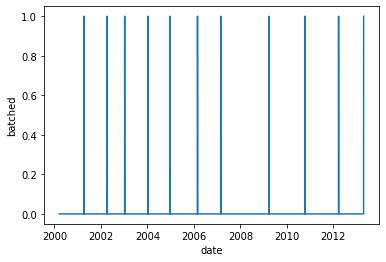

In [90]:
sns.lineplot(data=targetdatedataframe, x="date", y="batched")

In [92]:
targetdatedataframe.to_csv (r'C:\Users\bittu\RWTH\Thesis\easyroadfine2000sampltargetdatedataframe.csv', index= False, header=True)


<AxesSubplot:xlabel='tokenconsumed', ylabel='Count'>

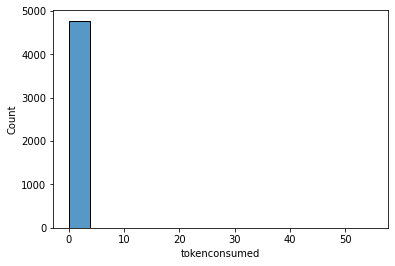

In [37]:
sns.histplot(data=targetdatedataframe[targetdatedataframe['tokenconsumed']>=0], x="tokenconsumed")

<AxesSubplot:xlabel='tokenconsumed', ylabel='Count'>

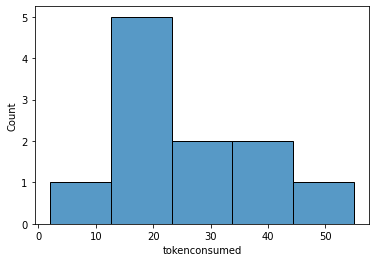

In [36]:
sns.histplot(data=targetdatedataframe[targetdatedataframe['tokenconsumed']>0], x="tokenconsumed")

In [38]:
tokenconsumedmean=targetdatedataframe[targetdatedataframe['tokenconsumed']!=0][["tokenconsumed"]].mean()
print(tokenconsumedmean)

tokenconsumed    26.272727
dtype: float64


In [177]:
for trace,case in zip(replayed_traces, log):
    print(trace)
    print("")
    print(case)
    for events in case:
        print(events)
        
        
    break

{'trace_is_fit': True, 'trace_fitness': 1.0, 'activated_transitions': [(n15, 'Create Fine'), (n17, 'Send Fine'), (n19, None), (n21, 'Insert Fine Notification'), (n22, None), (n20, None), (n24, None), (n29, 'Add penalty'), (n30, None), (n32, None), (n35, 'Send for Credit Collection')], 'reached_marking': ['n2:1'], 'enabled_transitions_in_marking': set(), 'transitions_with_problems': [], 'missing_tokens': 0, 'consumed_tokens': 13, 'remaining_tokens': 0, 'produced_tokens': 13}

{'attributes': {'concept:name': 'A10025'}, 'events': [{'amount': 36.0, 'totalPaymentAmount': 0.0, 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2007, 3, 22, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'dismissal': 'NIL', 'org:resource': '537', 'concept:name': 'Create Fine', 'vehicleClass': 'A', 'points': 0, 'article': 157}, '..', {'lifecycle:transition': 'complete', 'concept:name': 'Send for Credit Collection', 'time:timestamp': datetime.datetime(2009, 3, 30, 0, 0, t

# place n5 for original log
Inputs:  
    (n20, None)->n5,
    (n22, None)->n5
    
Outputs: 
    n5->(n30, 'Send Fine')

In [66]:
import pandas as pd
from pm4py.objects.petri_net.obj import PetriNet, Marking
input_transition_set={'n20','n22'}
output_transition_set={'n30'}
output_transition_label_set={ 'Send Fine'}
token_produced=0
token_consumed=0
token_left=0
df=pd.DataFrame()
for trace,case in zip(replayed_traces, log):
    if trace['trace_is_fit']==True:
        for active_trace in trace['activated_transitions']:
            if active_trace._Transition__get_name() in input_transition_set :
                token_produced=token_produced+1
            if active_trace._Transition__get_name() in output_transition_set:
                token_consumed=token_consumed+1
                for events in case:
                    if events['concept:name'] in output_transition_label_set:
                        row_df = pd.DataFrame([pd.Series([events['concept:name'], events['time:timestamp']])])
                        df = pd.concat([row_df, df], ignore_index=True)
            if token_consumed==9000:
                break
print(token_produced)
print(token_consumed)

df

9000
9000


,0,1
0,Send Fine,2008-11-18 00:00:00+01:00
1,Send Fine,2008-11-18 00:00:00+01:00
2,Send Fine,2008-11-18 00:00:00+01:00
3,Send Fine,2009-05-12 00:00:00+02:00
4,Send Fine,2009-05-12 00:00:00+02:00
...,...,...
8995,Send Fine,2007-07-17 00:00:00+02:00
8996,Send Fine,2007-07-17 00:00:00+02:00
8997,Send Fine,2007-07-17 00:00:00+02:00
8998,Send Fine,2006-12-12 00:00:00+01:00


In [95]:
#df['Date'] = pd.to_datetime(df[1], utc=True)
#df['Date'] = pd.to_datetime(df['DateTime']).dt.date
print(df[['Date',0]].groupby('Date').count())

              0
Date           
2006-11-15    1
2006-12-03    1
2006-12-04   14
2006-12-11   64
2006-12-12  245
2006-12-13  279
2006-12-14  188
2006-12-28   71
2007-04-03   48
2007-04-04    4
2007-06-26    6
2007-07-16  271
2007-08-01  372
2007-08-19  379
2007-08-21  413
2007-09-12  380
2007-09-28  402
2007-10-30  369
2007-12-09  375
2007-12-10  389
2007-12-26  357
2008-01-17  386
2008-02-08  397
2008-02-29  336
2008-04-16  230
2008-06-03  253
2008-06-04  153
2008-07-13  263
2008-07-29  358
2008-09-02  361
2008-09-10  381
2008-10-10  251
2008-10-20  260
2008-11-17  240
2008-12-09  147
2009-01-02  145
2009-01-13   52
2009-01-22    7
2009-01-27    1
2009-03-31   28
2009-05-11    9
2009-05-31   12
2009-06-11    6
2009-07-19    6
2009-07-27   18
2009-07-28   11
2009-09-17    3
2009-09-24    9
2009-11-10    1
2009-11-27    2
2009-12-08    2
2009-12-16    7
2009-12-17   21
2010-01-18   15
2010-07-27    1


In [56]:
print(len(replayed_traces))

150370


In [38]:
print(len(log))

150370


In [177]:
for trace,case in zip(replayed_traces, log):
    print(trace)
    print("")
    print(case)
    for events in case:
        print(events)
        
        
    break

{'trace_is_fit': True, 'trace_fitness': 1.0, 'activated_transitions': [(n15, 'Create Fine'), (n17, 'Send Fine'), (n19, None), (n21, 'Insert Fine Notification'), (n22, None), (n20, None), (n24, None), (n29, 'Add penalty'), (n30, None), (n32, None), (n35, 'Send for Credit Collection')], 'reached_marking': ['n2:1'], 'enabled_transitions_in_marking': set(), 'transitions_with_problems': [], 'missing_tokens': 0, 'consumed_tokens': 13, 'remaining_tokens': 0, 'produced_tokens': 13}

{'attributes': {'concept:name': 'A10025'}, 'events': [{'amount': 36.0, 'totalPaymentAmount': 0.0, 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2007, 3, 22, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'dismissal': 'NIL', 'org:resource': '537', 'concept:name': 'Create Fine', 'vehicleClass': 'A', 'points': 0, 'article': 157}, '..', {'lifecycle:transition': 'complete', 'concept:name': 'Send for Credit Collection', 'time:timestamp': datetime.datetime(2009, 3, 30, 0, 0, t

In [70]:
print(datetime.datetime(2006, 7, 24, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))))

NameError: name 'datetime' is not defined

In [8]:
net

places: [ n1, n10, n11, n12, n13, n14, n2, n3, n4, n5, n6, n7, n8, n9 ]
transitions: [ (n15, 'Create Fine'), (n16, None), (n17, 'Send Fine'), (n18, None), (n19, None), (n20, None), (n21, 'Insert Fine Notification'), (n22, None), (n23, 'Insert Date Appeal to Prefecture'), (n24, None), (n25, 'Appeal to Judge'), (n26, 'Send Appeal to Prefecture'), (n27, None), (n28, 'Receive Result Appeal from Prefecture'), (n29, 'Add penalty'), (n30, None), (n31, 'Notify Result Appeal to Offender'), (n32, None), (n33, 'Payment'), (n34, None), (n35, 'Send for Credit Collection') ]
arcs: [ (n15, 'Create Fine')->n3, (n16, None)->n4, (n17, 'Send Fine')->n5, (n18, None)->n6, (n19, None)->n10, (n19, None)->n8, (n20, None)->n7, (n21, 'Insert Fine Notification')->n9, (n22, None)->n11, (n23, 'Insert Date Appeal to Prefecture')->n11, (n24, None)->n12, (n25, 'Appeal to Judge')->n12, (n26, 'Send Appeal to Prefecture')->n13, (n27, None)->n12, (n28, 'Receive Result Appeal from Prefecture')->n12, (n29, 'Add penalty')->

# for sample log n6
Input
    (n29, 'Add penalty')->n6
    
Output-
    n6->(n30, None), 
    n6->(n31, 'Notify Result Appeal to Offender')

In [12]:
import pandas as pd
from pm4py.objects.petri_net.obj import PetriNet, Marking
initial_start=get_initial_start('n6')
input_transition_set=get_input_transitions(net,initial_start)
input_transition_label_set=get_labels_set(input_transition_set)
print(input_transition_set)
print(input_transition_label_set)
output_transition_set=get_output_transitions(net,initial_start)
output_transition_label_set=get_labels_set(output_transition_set)
print(output_transition_set)
print(output_transition_label_set)
token_produced=0
token_consumed=0
token_left=0
df=pd.DataFrame()
for trace,case in zip(replayed_traces, log):
    last_event=None
    first_event=None
    if trace['trace_is_fit']==True:
        for active_trace in trace['activated_transitions']:
            if active_trace in input_transition_set :
                for events in case:
                    if events['concept:name'] in input_transition_label_set:
                        last_event=events
            if active_trace in output_transition_set:
                for events in case:
                    if events['concept:name'] in output_transition_label_set and first_event is None:
                        first_event=events
    if last_event is not None and first_event is not None:
        token_produced=token_produced+1
        token_consumed=token_consumed+1
        row_df = pd.DataFrame([pd.Series([last_event['concept:name'], last_event['time:timestamp'],first_event['concept:name'], first_event['time:timestamp'], case.attributes['concept:name']])])
        df = pd.concat([row_df, df], ignore_index=True)
    
print(token_produced)
print(token_consumed)

df

[(n29, 'Add penalty'), (n17, 'Send Fine')]
{'Add penalty', 'Send Fine'}
[(n35, 'Send for Credit Collection'), (n33, 'Payment'), (n31, 'Notify Result Appeal to Offender')]
{'Payment', 'Notify Result Appeal to Offender', 'Send for Credit Collection'}
924
924


,0,1,2,3,4
0,Add penalty,2003-01-04 00:00:00+01:00,Send for Credit Collection,2004-01-10 00:00:00+01:00,V9913
1,Add penalty,2002-12-30 00:00:00+01:00,Send for Credit Collection,2004-01-10 00:00:00+01:00,V9901
2,Add penalty,2003-01-01 00:00:00+01:00,Send for Credit Collection,2004-01-10 00:00:00+01:00,V9627
3,Add penalty,2002-12-05 00:00:00+01:00,Send for Credit Collection,2004-01-10 00:00:00+01:00,V9449
4,Add penalty,2003-01-04 00:00:00+01:00,Send for Credit Collection,2004-01-10 00:00:00+01:00,V9422
...,...,...,...,...,...
919,Add penalty,2007-09-23 00:00:00+02:00,Send for Credit Collection,2009-03-30 00:00:00+02:00,A11624
920,Add penalty,2007-10-09 00:00:00+02:00,Payment,2007-10-11 00:00:00+02:00,A11466
921,Add penalty,2007-10-18 00:00:00+02:00,Send for Credit Collection,2009-03-30 00:00:00+02:00,A10729
922,Add penalty,2007-09-21 00:00:00+02:00,Send for Credit Collection,2009-03-30 00:00:00+02:00,A10131


In [13]:
df['StartDate'] = pd.to_datetime(df[1], utc=True)
df['StartDate'] = pd.to_datetime(df['StartDate']).dt.date
df['EndDate'] = pd.to_datetime(df[3], utc=True)
df['EndDate'] = pd.to_datetime(df['EndDate']).dt.date
df['TotalWaitingTime']=  (pd.to_datetime(df[3], utc=True)-pd.to_datetime(df[1], utc=True))
minstartdate=min(df['StartDate'])
maxenddate=max(df['EndDate'])

In [14]:

datedataframe = pd.DataFrame({'date':pd.date_range(start=minstartdate, end=maxenddate),'tokenproduced':0,'tokenconsumed':0,'tokenleft':0,'WaitingTime':0,'Count':0})
datedataframe

,date,tokenproduced,tokenconsumed,tokenleft,WaitingTime,Count
0,2000-03-22,0,0,0,0,0
1,2000-03-23,0,0,0,0,0
2,2000-03-24,0,0,0,0,0
3,2000-03-25,0,0,0,0,0
4,2000-03-26,0,0,0,0,0
...,...,...,...,...,...,...
4782,2013-04-25,0,0,0,0,0
4783,2013-04-26,0,0,0,0,0
4784,2013-04-27,0,0,0,0,0
4785,2013-04-28,0,0,0,0,0


In [15]:
df.sort_values(by='TotalWaitingTime')

,0,1,2,3,4,StartDate,EndDate,TotalWaitingTime
160,Add penalty,2002-02-04 00:00:00+01:00,Payment,2002-02-04 00:00:00+01:00,S67008,2002-02-03,2002-02-03,0 days 00:00:00
504,Add penalty,2006-06-03 00:00:00+02:00,Payment,2006-06-03 00:00:00+02:00,N88343,2006-06-02,2006-06-02,0 days 00:00:00
472,Add penalty,2005-07-06 00:00:00+02:00,Payment,2005-07-06 00:00:00+02:00,S100515,2005-07-05,2005-07-05,0 days 00:00:00
53,Add penalty,2005-06-07 00:00:00+02:00,Payment,2005-06-07 00:00:00+02:00,V15060,2005-06-06,2005-06-06,0 days 00:00:00
425,Add penalty,2008-12-22 00:00:00+01:00,Payment,2008-12-22 00:00:00+01:00,S126171,2008-12-21,2008-12-21,0 days 00:00:00
...,...,...,...,...,...,...,...,...
662,Add penalty,2002-08-16 00:00:00+02:00,Send for Credit Collection,2006-02-28 00:00:00+01:00,N40701,2002-08-15,2006-02-27,1292 days 01:00:00
665,Add penalty,2002-07-02 00:00:00+02:00,Send for Credit Collection,2006-02-28 00:00:00+01:00,N39945,2002-07-01,2006-02-27,1337 days 01:00:00
669,Add penalty,2002-07-02 00:00:00+02:00,Send for Credit Collection,2006-02-28 00:00:00+01:00,N39437,2002-07-01,2006-02-27,1337 days 01:00:00
673,Add penalty,2002-03-02 00:00:00+01:00,Send for Credit Collection,2006-02-28 00:00:00+01:00,N38130,2002-03-01,2006-02-27,1459 days 00:00:00


# Creating the dataframe

In [114]:
originalresponsedatedataframe=responsedatedataframe=targetdatedataframe
predictordatedataframe=predictordatedataframe.drop(['batched0_y', 'batched1_y', 'batched2_y', 'batched3_y', 'batched4_y', 'batched5_y', 'batched6_y'], axis=1)
predictordatedataframe

,date,tokenproduced,tokenconsumed,tokenleft,WaitingTime,Count,WaitingDays,AverageWaitingTime
7,2000-03-31,0,0,8,448 days 08:00:00,8,448,56.000000
8,2000-04-01,0,0,8,456 days 08:00:00,8,456,57.000000
9,2000-04-02,0,0,8,464 days 08:00:00,8,464,58.000000
10,2000-04-03,1,1,8,472 days 08:00:00,9,472,52.444444
11,2000-04-04,2,0,10,480 days 12:00:00,10,480,48.000000
...,...,...,...,...,...,...,...,...
4749,2013-03-25,0,0,0,0:00:00,0,0,0.000000
4750,2013-03-26,0,0,0,0:00:00,0,0,0.000000
4751,2013-03-27,1,0,1,0 days 01:00:00,1,0,0.000000
4752,2013-03-28,0,1,0,1 days 00:00:00,1,1,1.000000


In [115]:
import datetime
#add seven days
def categorise(row,numdays):   
    return row['date'] +  datetime.timedelta(days=numdays)
for i in range (7):
    responsedatedataframe['date'] = responsedatedataframe.apply(lambda row: categorise(row,1), axis=1)
    predictordatedataframe=predictordatedataframe.merge(responsedatedataframe[['date','batched']].rename({'batched': 'batched'+str(i)}, axis=1), on='date', how='left')

In [116]:
predictordatedataframe=predictordatedataframe.dropna()
predictordatedataframe.count()

date                  4740
tokenproduced         4740
tokenconsumed         4740
tokenleft             4740
WaitingTime           4740
Count                 4740
WaitingDays           4740
AverageWaitingTime    4740
batched0              4740
batched1              4740
batched2              4740
batched3              4740
batched4              4740
batched5              4740
batched6              4740
dtype: int64

In [117]:
predictordatedataframe

,date,tokenproduced,tokenconsumed,tokenleft,WaitingTime,Count,WaitingDays,AverageWaitingTime,batched0,batched1,batched2,batched3,batched4,batched5,batched6
7,2000-04-07,0,0,11,511 days 14:00:00,11,511,46.454545,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2000-04-08,0,1,10,522 days 12:00:00,11,522,47.454545,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2000-04-09,0,0,10,437 days 13:00:00,10,437,43.700000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,2000-04-10,0,0,10,447 days 13:00:00,10,447,44.700000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,2000-04-11,0,0,10,457 days 13:00:00,10,457,45.700000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4742,2013-03-25,0,0,0,0:00:00,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4743,2013-03-26,0,0,0,0:00:00,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4744,2013-03-27,1,0,1,0 days 01:00:00,1,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4745,2013-03-28,0,1,0,1 days 00:00:00,1,1,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


1851    0.0
3048    0.0
4541    0.0
3034    0.0
2697    0.0
       ... 
4685    0.0
752     0.0
1188    0.0
3336    0.0
1488    0.0
Name: batched0, Length: 1422, dtype: float64
        0
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
...   ...
1417  0.0
1418  0.0
1419  0.0
1420  0.0
1421  0.0

[1422 rows x 1 columns]
Mean absolute error LR- 0.005625879043600563
Mean Squared error LR- 0.07500586006173493
Accuracy: 0.9943741209563994
F1: 0.498589562764457
Precision: 0.49894142554693016
Recall: 0.49823819591261453


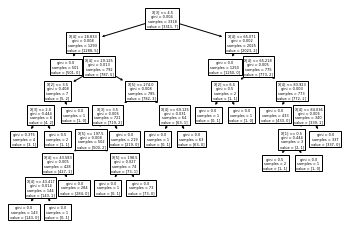

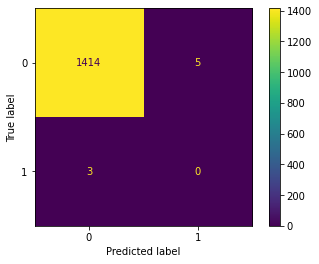

4194    0.0
2316    0.0
3947    0.0
2633    0.0
2219    0.0
       ... 
3332    0.0
2835    0.0
593     0.0
244     0.0
3874    0.0
Name: batched1, Length: 1422, dtype: float64
        0
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
...   ...
1417  0.0
1418  0.0
1419  0.0
1420  0.0
1421  0.0

[1422 rows x 1 columns]
Mean absolute error LR- 0.0035161744022503515
Mean Squared error LR- 0.059297338913735
Accuracy: 0.9964838255977496
F1: 0.4991194082423389
Precision: 0.49859254046446166
Recall: 0.49964739069111425


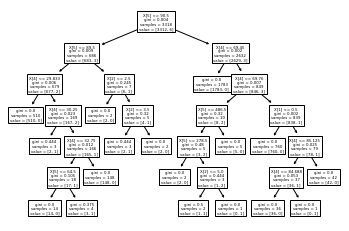

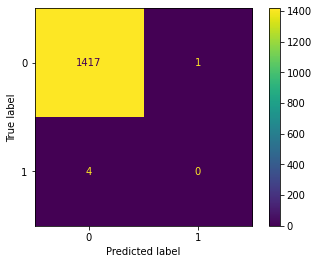

3087    0.0
3099    0.0
298     0.0
2167    0.0
3509    0.0
       ... 
3305    0.0
4538    0.0
2313    0.0
2268    0.0
3797    0.0
Name: batched2, Length: 1422, dtype: float64
        0
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
...   ...
1417  0.0
1418  0.0
1419  0.0
1420  0.0
1421  0.0

[1422 rows x 1 columns]
Mean absolute error LR- 0.002109704641350211
Mean Squared error LR- 0.04593152121746253
Accuracy: 0.9978902953586498
F1: 0.49947201689545934
Precision: 0.49929627023223083
Recall: 0.49964788732394366


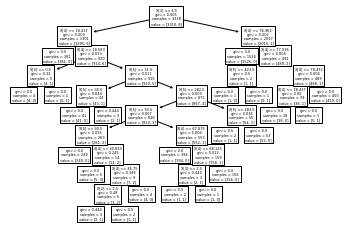

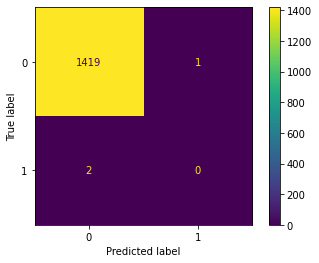

2779    0.0
3792    0.0
1794    0.0
664     0.0
3177    0.0
       ... 
1988    0.0
4367    0.0
2971    0.0
2862    0.0
1947    0.0
Name: batched3, Length: 1422, dtype: float64
        0
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
...   ...
1417  0.0
1418  0.0
1419  0.0
1420  0.0
1421  0.0

[1422 rows x 1 columns]
Mean absolute error LR- 0.0028129395218002813
Mean Squared error LR- 0.053037152278382
Accuracy: 0.9971870604781997
F1: 0.4992957746478873
Precision: 0.49859353023909986
Recall: 0.5


C:\Users\bittu\anaconda3\envs\env-IDS2020\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


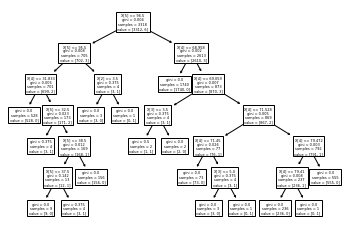

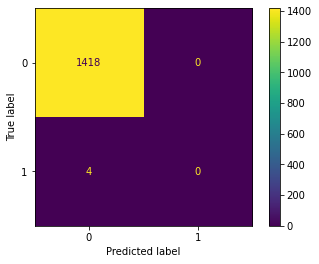

1862    0.0
1226    0.0
340     0.0
1745    0.0
3962    0.0
       ... 
3859    0.0
4529    0.0
2715    0.0
2351    0.0
2817    0.0
Name: batched4, Length: 1422, dtype: float64
        0
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
...   ...
1417  0.0
1418  0.0
1419  0.0
1420  0.0
1421  0.0

[1422 rows x 1 columns]
Mean absolute error LR- 0.004219409282700422
Mean Squared error LR- 0.06495698024616309
Accuracy: 0.9957805907172996
F1: 0.4989429175475687
Precision: 0.4978902953586498
Recall: 0.5


C:\Users\bittu\anaconda3\envs\env-IDS2020\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


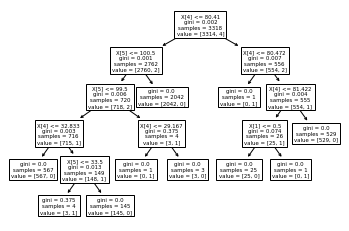

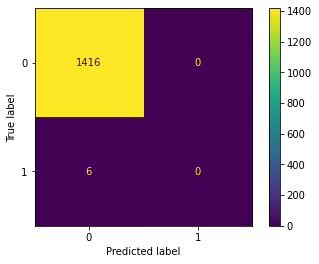

3616    0.0
2266    0.0
2627    0.0
948     0.0
1429    0.0
       ... 
1029    0.0
92      0.0
4364    0.0
4618    0.0
2178    0.0
Name: batched5, Length: 1422, dtype: float64
        0
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
...   ...
1417  0.0
1418  0.0
1419  0.0
1420  0.0
1421  0.0

[1422 rows x 1 columns]
Mean absolute error LR- 0.0028129395218002813
Mean Squared error LR- 0.053037152278382
Accuracy: 0.9971870604781997
F1: 0.4992957746478873
Precision: 0.4989444053483462
Recall: 0.4996476391825229


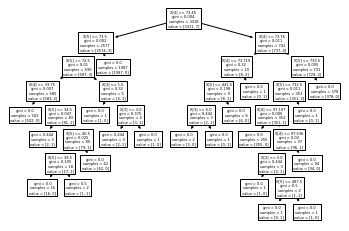

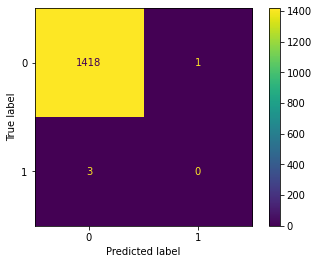

654     0.0
1478    0.0
2982    0.0
1674    0.0
1647    0.0
       ... 
1068    0.0
3998    0.0
2193    0.0
2043    0.0
3959    0.0
Name: batched6, Length: 1422, dtype: float64
        0
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
...   ...
1417  0.0
1418  0.0
1419  0.0
1420  0.0
1421  0.0

[1422 rows x 1 columns]
Mean absolute error LR- 0.004219409282700422
Mean Squared error LR- 0.06495698024616309
Accuracy: 0.9957805907172996
F1: 0.4989429175475687
Precision: 0.4992947813822285
Recall: 0.49859154929577465


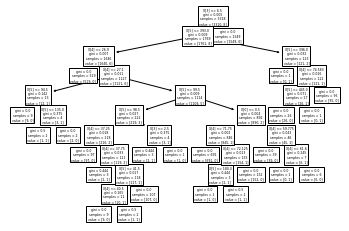

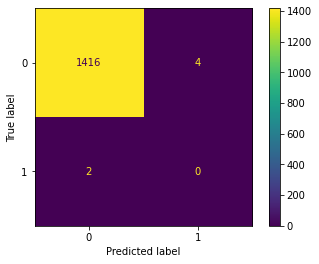

In [119]:
from sklearn import tree,metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

def traindtmultiple(y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(x_train, y_train)
    prediction=clf.predict(x_test)
    tree.plot_tree(clf)
    Y_test_pred = pd.DataFrame(prediction)
    print(y_test)
    print(Y_test_pred)
    print("Mean absolute error LR-",metrics.mean_absolute_error(y_test, Y_test_pred))
    metrics.mean_squared_error(y_test, Y_test_pred)
    print("Mean Squared error LR-",np.sqrt(metrics.mean_squared_error(y_test, Y_test_pred)))
    print("Accuracy:",accuracy_score(y_test, Y_test_pred))
    print("F1:",f1_score(y_test, Y_test_pred, average="macro"))
    print("Precision:",precision_score(y_test, Y_test_pred, average="macro"))
    print("Recall:",recall_score(y_test, Y_test_pred, average="macro"))
    cm = confusion_matrix(y_test, Y_test_pred)
    cm = confusion_matrix(y_test, Y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

x = predictordatedataframe[['tokenproduced', 'tokenconsumed', 'tokenleft','Count','AverageWaitingTime','WaitingDays']]
for i in range(7):
    y = predictordatedataframe['batched'+str(i)].fillna(0)
    traindtmultiple(y)


3809    0.0
2559    0.0
1977    0.0
3393    0.0
395     0.0
       ... 
1053    0.0
2646    0.0
1222    0.0
549     0.0
2628    0.0
Name: batched0, Length: 1422, dtype: float64
      0
0     1
1     1
2     1
3     1
4     1
...  ..
1417  1
1418  1
1419  1
1420  1
1421  1

[1422 rows x 1 columns]
Mean absolute error LR- 0.9964838255977496
Mean Squared error LR- 0.9982403646405758
Accuracy: 0.0035161744022503515
F1: 0.00350385423966363
Precision: 0.0017580872011251757
Recall: 0.5


C:\Users\bittu\anaconda3\envs\env-IDS2020\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


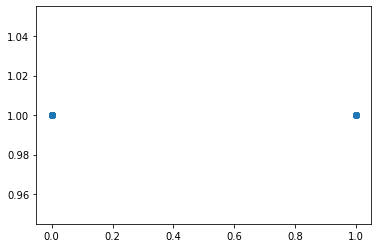

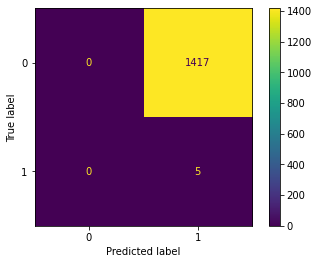

2819    0.0
3345    0.0
3746    0.0
2943    0.0
2929    0.0
       ... 
2172    0.0
4269    0.0
3775    0.0
124     0.0
4053    0.0
Name: batched1, Length: 1422, dtype: float64
      0
0     1
1     1
2     1
3     1
4     1
...  ..
1417  1
1418  1
1419  1
1420  1
1421  1

[1422 rows x 1 columns]
Mean absolute error LR- 0.9978902953586498
Mean Squared error LR- 0.9989445907349666
Accuracy: 0.002109704641350211
F1: 0.0021052631578947364
Precision: 0.0010548523206751054
Recall: 0.5


C:\Users\bittu\anaconda3\envs\env-IDS2020\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


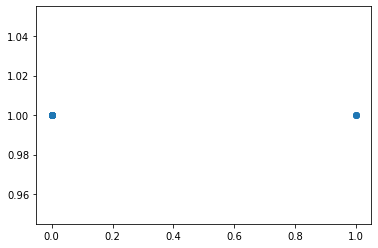

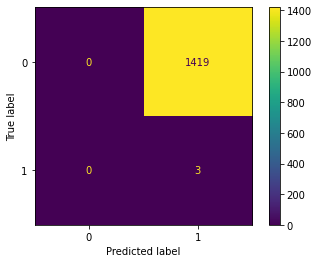

201     0.0
3150    0.0
492     0.0
1597    0.0
4095    0.0
       ... 
2702    0.0
3846    0.0
4030    0.0
2092    0.0
3434    0.0
Name: batched2, Length: 1422, dtype: float64
      0
0     1
1     1
2     1
3     1
4     1
...  ..
1417  1
1418  1
1419  1
1420  1
1421  1

[1422 rows x 1 columns]
Mean absolute error LR- 0.9964838255977496
Mean Squared error LR- 0.9982403646405758
Accuracy: 0.0035161744022503515
F1: 0.00350385423966363
Precision: 0.0017580872011251757
Recall: 0.5


C:\Users\bittu\anaconda3\envs\env-IDS2020\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


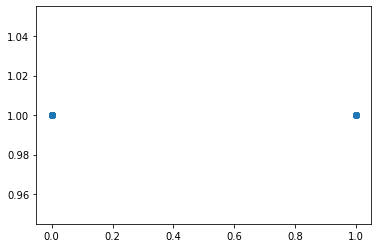

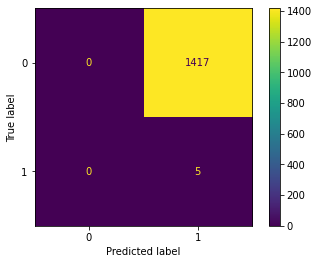

402     0.0
1251    0.0
3290    0.0
1149    0.0
3745    0.0
       ... 
2497    0.0
3387    0.0
1988    0.0
2775    0.0
3168    0.0
Name: batched3, Length: 1422, dtype: float64
      0
0     1
1     1
2     1
3     1
4     1
...  ..
1417  1
1418  1
1419  1
1420  1
1421  1

[1422 rows x 1 columns]
Mean absolute error LR- 0.9985935302390999
Mean Squared error LR- 0.9992965176758598
Accuracy: 0.0014064697609001407
F1: 0.0014044943820224719
Precision: 0.0007032348804500703
Recall: 0.5


C:\Users\bittu\anaconda3\envs\env-IDS2020\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


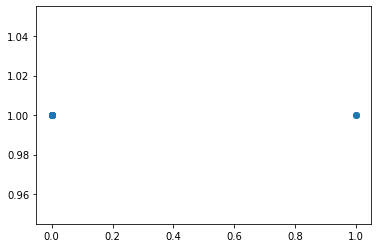

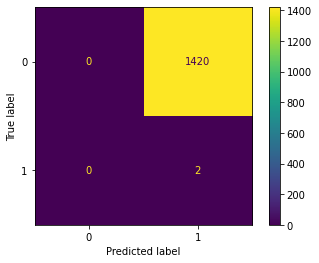

2170    0.0
4119    0.0
3671    0.0
1838    0.0
1944    0.0
       ... 
1817    0.0
4209    0.0
2835    0.0
1204    0.0
1545    0.0
Name: batched4, Length: 1422, dtype: float64
      0
0     1
1     1
2     1
3     1
4     1
...  ..
1417  1
1418  1
1419  1
1420  1
1421  1

[1422 rows x 1 columns]
Mean absolute error LR- 0.9964838255977496
Mean Squared error LR- 0.9982403646405758
Accuracy: 0.0035161744022503515
F1: 0.00350385423966363
Precision: 0.0017580872011251757
Recall: 0.5


C:\Users\bittu\anaconda3\envs\env-IDS2020\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


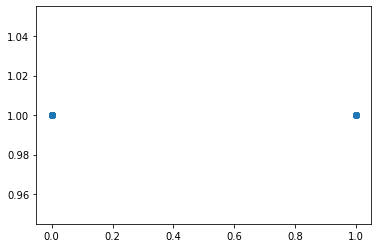

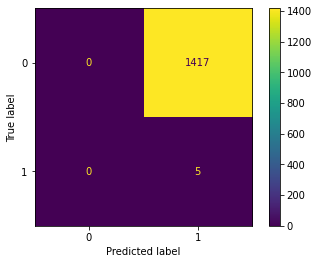

2611    0.0
2785    0.0
1812    0.0
2144    0.0
2739    0.0
       ... 
3103    0.0
988     0.0
1761    0.0
1581    0.0
3749    0.0
Name: batched5, Length: 1422, dtype: float64
      0
0     1
1     1
2     1
3     1
4     1
...  ..
1417  1
1418  1
1419  1
1420  1
1421  1

[1422 rows x 1 columns]
Mean absolute error LR- 0.9971870604781997
Mean Squared error LR- 0.9985925397669461
Accuracy: 0.0028129395218002813
F1: 0.0028050490883590466
Precision: 0.0014064697609001407
Recall: 0.5


C:\Users\bittu\anaconda3\envs\env-IDS2020\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


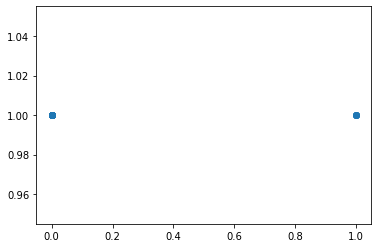

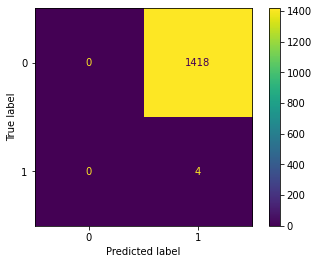

2150    0.0
660     0.0
637     0.0
447     0.0
3598    0.0
       ... 
640     0.0
1198    0.0
1781    0.0
305     0.0
2343    0.0
Name: batched6, Length: 1422, dtype: float64
      0
0     1
1     1
2     1
3     1
4     1
...  ..
1417  1
1418  1
1419  1
1420  1
1421  1

[1422 rows x 1 columns]
Mean absolute error LR- 0.9985935302390999
Mean Squared error LR- 0.9992965176758598
Accuracy: 0.0014064697609001407
F1: 0.0014044943820224719
Precision: 0.0007032348804500703
Recall: 0.5


C:\Users\bittu\anaconda3\envs\env-IDS2020\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


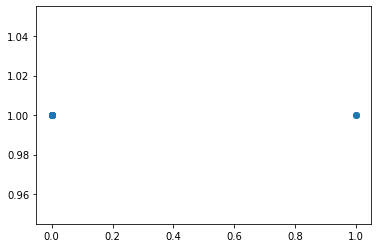

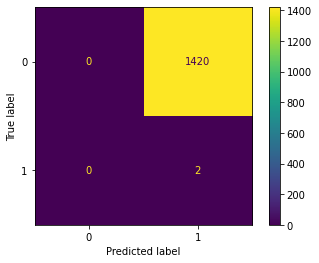

In [121]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
def trainlrmultiple(y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
    model = LinearRegression()
    model.fit(x_train, y_train)
    pd.DataFrame(model.coef_, x.columns, columns = ['Coeff'])
    #Y_test_pred = pd.DataFrame(model.predict(x_test)).applymap(lambda x: 1 if x>0.5 else 0)
    Y_test_pred = pd.DataFrame(model.predict(x_test)).applymap(lambda x: 0 if x>0.5 else 1)
    plt.scatter(y_test, Y_test_pred)
    from sklearn import metrics
    print(y_test)
    print(Y_test_pred)
    print("Mean absolute error LR-",metrics.mean_absolute_error(y_test, Y_test_pred))
    metrics.mean_squared_error(y_test, Y_test_pred)
    print("Mean Squared error LR-",np.sqrt(metrics.mean_squared_error(y_test, Y_test_pred)))
    print("Accuracy:",accuracy_score(y_test, Y_test_pred))
    print("F1:",f1_score(y_test, Y_test_pred, average="macro"))
    print("Precision:",precision_score(y_test, Y_test_pred, average="macro"))
    print("Recall:",recall_score(y_test, Y_test_pred, average="macro"))
    cm = confusion_matrix(y_test, Y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

x = predictordatedataframe[['tokenproduced', 'tokenconsumed', 'tokenleft','Count','AverageWaitingTime','WaitingDays']]
for i in range(7):
    y = predictordatedataframe['batched'+str(i)].fillna(0)
    trainlrmultiple(y)


In [23]:
datedataframe['WaitingTime']=pd.to_timedelta(datedataframe['WaitingTime'])

In [39]:
df

,0,1,2,3,4,StartDate,EndDate,TotalWaitingTime
0,Add penalty,2003-01-04 00:00:00+01:00,Send for Credit Collection,2004-01-10 00:00:00+01:00,V9913,2003-01-03,2004-01-09,371 days
1,Add penalty,2002-12-30 00:00:00+01:00,Send for Credit Collection,2004-01-10 00:00:00+01:00,V9901,2002-12-29,2004-01-09,376 days
2,Add penalty,2003-01-01 00:00:00+01:00,Send for Credit Collection,2004-01-10 00:00:00+01:00,V9627,2002-12-31,2004-01-09,374 days
3,Add penalty,2002-12-05 00:00:00+01:00,Send for Credit Collection,2004-01-10 00:00:00+01:00,V9449,2002-12-04,2004-01-09,401 days
4,Add penalty,2003-01-04 00:00:00+01:00,Send for Credit Collection,2004-01-10 00:00:00+01:00,V9422,2003-01-03,2004-01-09,371 days
...,...,...,...,...,...,...,...,...
919,Add penalty,2007-09-23 00:00:00+02:00,Send for Credit Collection,2009-03-30 00:00:00+02:00,A11624,2007-09-22,2009-03-29,554 days
920,Add penalty,2007-10-09 00:00:00+02:00,Payment,2007-10-11 00:00:00+02:00,A11466,2007-10-08,2007-10-10,2 days
921,Add penalty,2007-10-18 00:00:00+02:00,Send for Credit Collection,2009-03-30 00:00:00+02:00,A10729,2007-10-17,2009-03-29,529 days
922,Add penalty,2007-09-21 00:00:00+02:00,Send for Credit Collection,2009-03-30 00:00:00+02:00,A10131,2007-09-20,2009-03-29,556 days


In [ ]:
from datetime import date
for index, row in datedataframe.iterrows():
    currentdate=row['date']
    produced=0
    left=0
    consumed=0
    waiting=pd.Timedelta(days=0)
    count=0
    for indexdata, rowdata in df.iterrows():
        StartDate=rowdata['StartDate']
        EndDate=rowdata['EndDate']
        TotalWaitingTime=rowdata['TotalWaitingTime']
        if currentdate.date()==StartDate:
            produced=produced+1
        if currentdate.date()==EndDate:
            consumed=consumed+1
        if currentdate.date()<EndDate and currentdate.date()>=StartDate:
            left=left+1
        if currentdate.date()<=EndDate and currentdate.date()>=StartDate:
            if waiting is None:
                waiting=TotalWaitingTime
            else:
                waiting=waiting+TotalWaitingTime
            count=count+1
    datedataframe.at[index, 'tokenproduced']=produced
    datedataframe.at[index, 'tokenconsumed']=consumed
    datedataframe.at[index, 'tokenleft']=left
    datedataframe.at[index, 'WaitingTime']=waiting
    datedataframe.at[index, 'Count']=count

for index, row in datedataframe.iterrows():
    date=row['date']
    print(typedate.date())
    break
for indexdata, rowdata in df.iterrows():
    StartDate=rowdata['StartDate']
    break
from datetime import date 
datenew=date(2001, 1, 1)
print(type(StartDate))

datedataframe.sort_values(by='WaitingTime')
#datedataframe['WaitingTime']=datedataframe['WaitingTime'].fillna((pd.Timedelta(days=0)))

maxenddate=max(datedataframe['WaitingTime'])
print(maxenddate)

datedataframe.to_csv (r'C:\Users\bittu\RWTH\Thesis\dataset.csv', index = False, header=True)

In [24]:
def categorise(row):   
    if row['WaitingTime'].days > 5000 :
        return 1
    return 0

datedataframe['delayed'] = datedataframe.apply(lambda row: categorise(row), axis=1)

In [134]:
def categorise(row):   
    if row['WaitingTime'].days >= 50  and row['WaitingTime'].days < 100 :
        return 1
    if row['WaitingTime'].days >= 100   and row['WaitingTime'].days < 500:
        return 2
    if row['WaitingTime'].days >= 500 and row['WaitingTime'].days < 5000:
        return 3
    if row['WaitingTime'].days >= 5000 and row['WaitingTime'].days < 20000:
        return 4
    if row['WaitingTime'].days >= 20000 and row['WaitingTime'].days < 50000:
        return 5
    if row['WaitingTime'].days >= 50000 and row['WaitingTime'].days < 100000:
        return 6
    return 0

datedataframe['delayed'] = datedataframe.apply(lambda row: categorise(row), axis=1)

In [143]:
def categorise(row):   
    if row['WaitingTime'].days >= 50  and row['WaitingTime'].days < 5000 :
        return 1
    if row['WaitingTime'].days >= 5000 and row['WaitingTime'].days < 50000:
        return 2
    if row['WaitingTime'].days >= 50000 and row['WaitingTime'].days < 100000:
        return 3
    return 0

datedataframe['delayed'] = datedataframe.apply(lambda row: categorise(row), axis=1)

In [137]:
def categorise(row):   
    return row['WaitingTime'].days
    
datedataframe['WaitingDays'] = datedataframe.apply(lambda row: categorise(row), axis=1)
 
def categorise(row):   
    if row['Count']==0:
        return 0
    return row['WaitingTime'].days/row['Count']

datedataframe['AverageWaitingTime'] = datedataframe.apply(lambda row: categorise(row), axis=1)

In [38]:
datedataframe[datedataframe['delayed']==0]

,date,tokenproduced,tokenconsumed,tokenleft,WaitingTime,Count,delayed
0,2000-03-22,3,0,3,62 days 21:00:00,3,0
1,2000-03-23,0,0,3,62 days 21:00:00,3,0
2,2000-03-24,0,0,3,62 days 21:00:00,3,0
3,2000-03-25,0,0,3,62 days 21:00:00,3,0
4,2000-03-26,0,0,3,62 days 21:00:00,3,0
...,...,...,...,...,...,...,...
4782,2013-04-25,0,0,1,13 days 00:00:00,1,0
4783,2013-04-26,0,0,1,13 days 00:00:00,1,0
4784,2013-04-27,0,0,1,13 days 00:00:00,1,0
4785,2013-04-28,0,0,1,13 days 00:00:00,1,0


In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

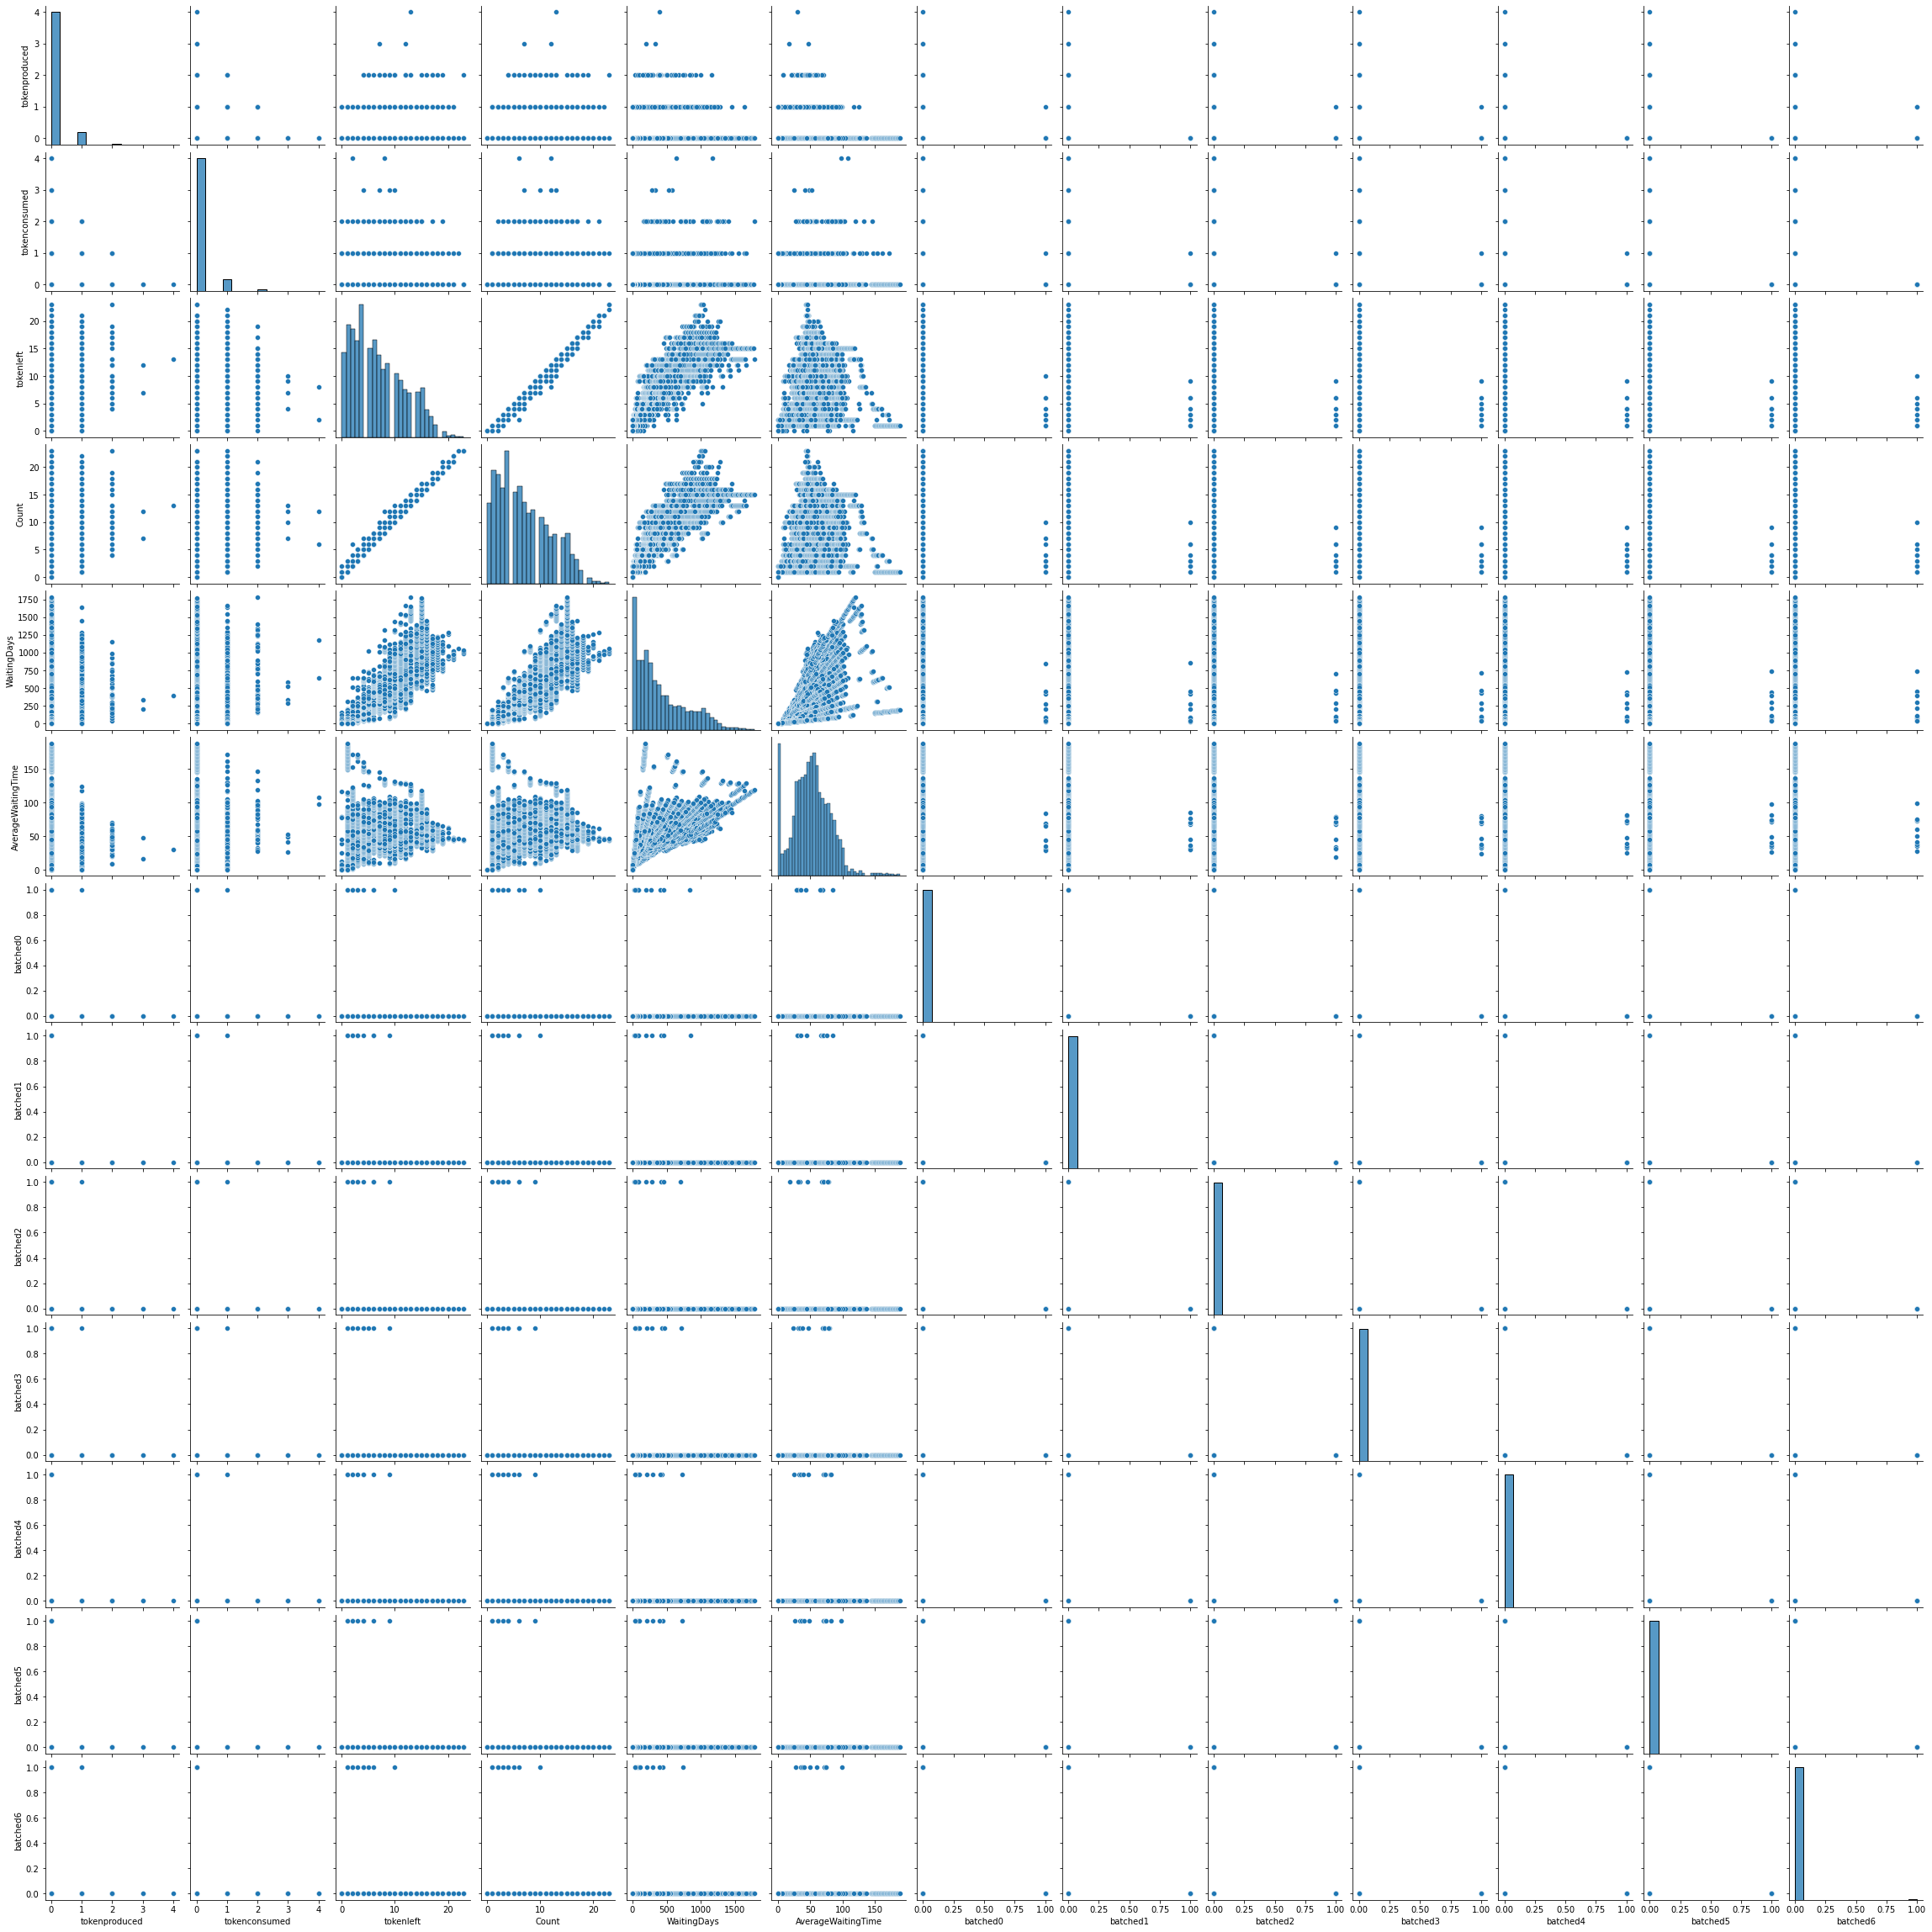

In [122]:
sns.pairplot(predictordatedataframe)

[-0.00150705  0.00048249  0.00046753  0.00095003]
0.854650483021639
Mean absolute error DT- 0.05648742631098671
Mean Squared error DT- 0.12705211451500256


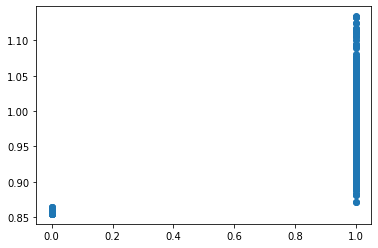

In [32]:
x = datedataframe[['tokenproduced', 'tokenconsumed', 'tokenleft','Count']]

y = datedataframe['delayed']

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(x_train, y_train)

print(model.coef_)

print(model.intercept_)

pd.DataFrame(model.coef_, x.columns, columns = ['Coeff'])

predictions = model.predict(x_test)

plt.scatter(y_test, predictions)

#plt.hist(y_test - predictions)

from sklearn import metrics


print("Mean absolute error DT-",metrics.mean_absolute_error(y_test, predictions))

metrics.mean_squared_error(y_test, predictions)

print("Mean Squared error DT-",np.sqrt(metrics.mean_squared_error(y_test, predictions)))


[Text(167.4, 163.07999999999998, 'X[2] <= 10.0\ngini = 0.037\nsamples = 3350\nvalue = [64, 3286]'),
 Text(83.7, 54.360000000000014, 'gini = 0.0\nsamples = 64\nvalue = [64, 0]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.0\nsamples = 3286\nvalue = [0, 3286]')]

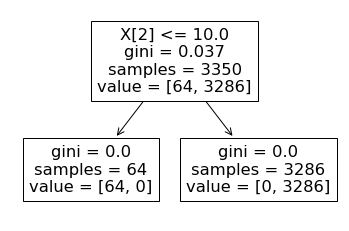

In [28]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)
prediction=clf.predict(x_test)
tree.plot_tree(clf)

In [29]:
print(prediction)

[1 1 1 ... 1 1 1]


In [33]:
print("Mean absolute error DT-",metrics.mean_absolute_error(y_test, prediction))

metrics.mean_squared_error(y_test, prediction)

print("Mean Squared error DT-",np.sqrt(metrics.mean_squared_error(y_test, prediction)))

Mean absolute error DT- 0.038274182324286705
Mean Squared error DT- 0.19563788570797505


# Miscellaneous

In [164]:
df['Date'] = pd.to_datetime(df[1], utc=True)
df['Date'] = pd.to_datetime(df['Date']).dt.date
df=df[['Date',0]].groupby(['Date',0]).size().sort_values(ascending=False).reset_index(name='count') 

df=df.pivot(index='Date', columns=0, values='count').fillna(0)
df['TokenProduced'] = df[input_transition_label_set].sum(axis=1)
df['TokenConsumed'] = df[output_transition_label_set].sum(axis=1)
df['TokenLeft'] = df.loc[df.TokenProduced > df.TokenConsumed].eval('TokenProduced - TokenConsumed').

In [172]:
df=df.fillna(0)
print(df.sort_values(by=['TokenLeft'],ascending=True))

0           Add penalty  Notify Result Appeal to Offender  Payment  Send Fine  \
Date                                                                            
2000-01-13          0.0                               0.0      1.0        0.0   
2006-11-29          0.0                               0.0      1.0        0.0   
2006-11-30          0.0                               0.0      1.0        0.0   
2006-12-01          0.0                               0.0      1.0        0.0   
2006-12-04          0.0                               0.0      1.0        1.0   
...                 ...                               ...      ...        ...   
2000-12-04         14.0                               0.0      0.0        0.0   
2002-07-28          0.0                               0.0      1.0       16.0   
2002-11-09         16.0                               0.0      0.0        0.0   
2003-07-25         16.0                               0.0      0.0        0.0   
2004-01-15         20.0     

In [154]:
df=df.pivot(index='Date', columns=0, values='count').fillna(0)
df['TokenProduced'] = df[input_transition_label_set].sum(axis=1)
df['TokenConsumed'] = df[output_transition_label_set].sum(axis=1)
df['TokenLeft'] = df.loc[df.TokenProduced > df.TokenConsumed].eval('TokenProduced - TokenConsumed')
TokenLeft

In [175]:

print(df.sum()  )


0
Add penalty                         1740.0
Notify Result Appeal to Offender       2.0
Payment                              817.0
Send Fine                            344.0
Send for Credit Collection           742.0
TokenProduced                       2084.0
TokenConsumed                       1561.0
TokenLeft                           1963.0
dtype: float64


In [114]:
import pandas as pd
from pm4py.objects.petri_net.obj import PetriNet, Marking

input_transition_set={'n29'}
output_transition_set={'n30','n31'}
input_transition_label_set={ 'Add penalty'}
output_transition_label_set={ 'None','Notify Result Appeal to Offender'}
token_produced=0
token_consumed=0
token_left=0
df=pd.DataFrame()
for trace,case in zip(replayed_traces, log):
    if trace['trace_is_fit']==True:
        for active_trace in trace['activated_transitions']:
            if active_trace._Transition__get_name() in input_transition_set :
                token_produced=token_produced+1
                for events in case:
                    if events['concept:name'] in input_transition_label_set:
                        row_df = pd.DataFrame([pd.Series([events['concept:name'], events['time:timestamp']])])
                        df = pd.concat([row_df, df], ignore_index=True)
            if active_trace._Transition__get_name() in output_transition_set:
                token_consumed=token_consumed+1
                for events in case:
                    if events['concept:name'] in output_transition_label_set:
                        row_df = pd.DataFrame([pd.Series([events['concept:name'], events['time:timestamp']])])
                        df = pd.concat([row_df, df], ignore_index=True)
        
print(token_produced)
print(token_consumed)

df

870
1214


,0,1
0,Add penalty,2003-01-04 00:00:00+01:00
1,Add penalty,2002-12-30 00:00:00+01:00
2,Add penalty,2003-01-01 00:00:00+01:00
3,Add penalty,2002-12-05 00:00:00+01:00
4,Add penalty,2003-01-04 00:00:00+01:00
...,...,...
866,Add penalty,2007-09-23 00:00:00+02:00
867,Add penalty,2007-10-09 00:00:00+02:00
868,Add penalty,2007-10-18 00:00:00+02:00
869,Add penalty,2007-09-21 00:00:00+02:00


In [73]:
#df['Date'] = pd.to_datetime(df[1], utc=True)
#df['Date'] = pd.to_datetime(df['DateTime']).dt.date
print(df[['Date',0]].groupby('Date').count())

NameError: name 'PetriNet' is not defined

[(n31, 'Notify Result Appeal to Offender'),
 (n33, 'Payment'),
 (n35, 'Send for Credit Collection')]